In [1]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.signal import butter, sosfilt
import soundfile as sf

import os

## 음성데이터 전처리를 위한 노이즈 시각화

In [2]:
def calculate_snr(signal, noise):
    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

In [3]:
def calculate_snr_for_all_files(directory):
    snr_values = []
    for filename in os.listdir(directory):
        if filename.endswith('.ogg'):
            audio_path = os.path.join(directory, filename)
            audio, sr = librosa.load(audio_path, sr=None)
            noise = audio - librosa.effects.harmonic(audio)
            snr = calculate_snr(audio, noise)
            snr_values.append(snr)
            print(f'{filename}: SNR = {snr} dB')
    return snr_values

In [4]:
def analyze_snr(snr_values):
    plt.figure(figsize=(10, 6))
    plt.hist(snr_values, bins=20, edgecolor='black')
    plt.title('SNR Distribution Across All Audio Files')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Frequency')
    plt.show()

    mean_snr = np.mean(snr_values)
    median_snr = np.median(snr_values)
    std_snr = np.std(snr_values)

    print(f'Mean SNR: {mean_snr} dB')
    print(f'Median SNR: {median_snr} dB')
    print(f'Standard Deviation of SNR: {std_snr} dB')

    return mean_snr, median_snr, std_snr

In [ ]:
# Directory containing audio files
directory = './train'

# Calculate SNR for all files
snr_values = calculate_snr_for_all_files(directory)

# Analyze SNR values
mean_snr, median_snr, std_snr = analyze_snr(snr_values)

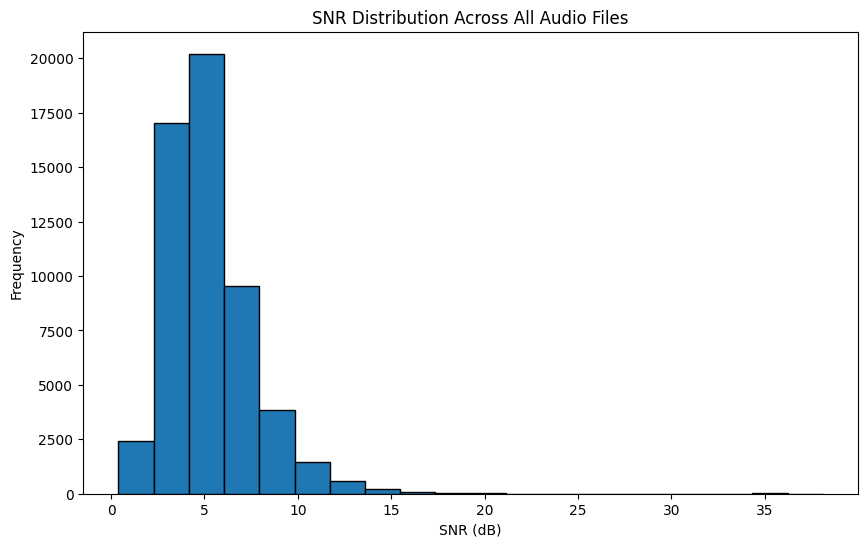

Mean SNR: 5.267247370832606 dB
Median SNR: 4.821002185344696 dB
Standard Deviation of SNR: 2.3847295894559473 dB


In [5]:
#np.save('./snr_values.npy', snr_values)
snr_values = np.load('./snr_values.npy')
mean_snr, median_snr, std_snr = analyze_snr(snr_values)

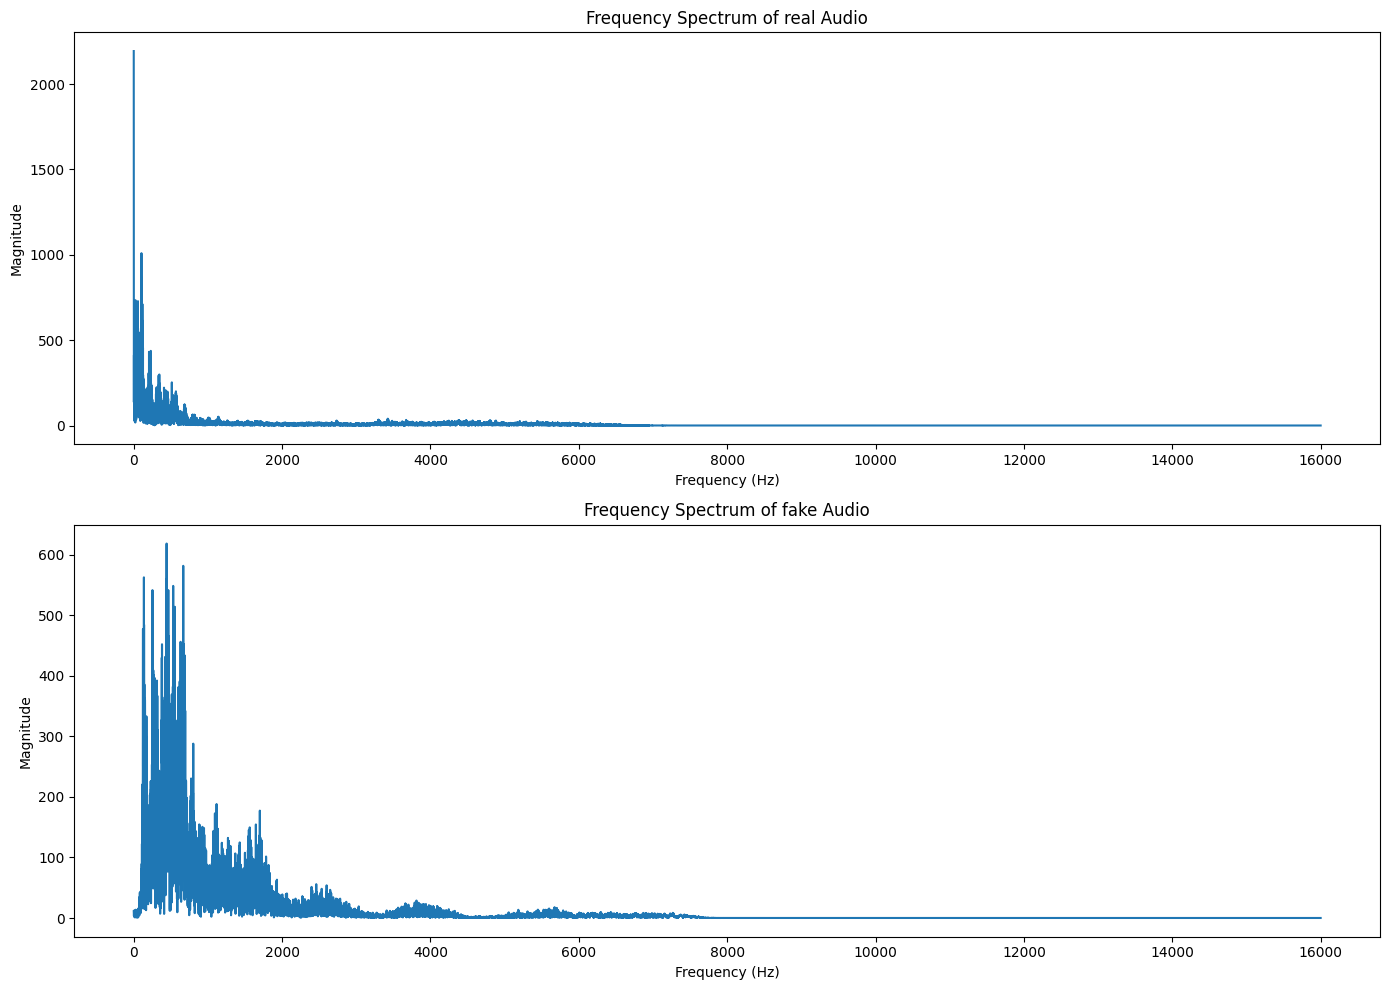

In [10]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# 첫 번째 음성 파일 로드
audio_path1 = './train/RBOJKPRL.ogg'
audio1, sr1 = librosa.load(audio_path1, sr=None)

# 두 번째 음성 파일 로드
audio_path2 = './train/FRUWZOVC.ogg'
audio2, sr2 = librosa.load(audio_path2, sr=None)

# 푸리에 변환 (첫 번째 음성 파일)
fft_spectrum1 = np.fft.fft(audio1)
frequencies1 = np.fft.fftfreq(len(fft_spectrum1), 1/sr1)

# 푸리에 변환 (두 번째 음성 파일)
fft_spectrum2 = np.fft.fft(audio2)
frequencies2 = np.fft.fftfreq(len(fft_spectrum2), 1/sr2)

# 주파수 스펙트럼 시각화
plt.figure(figsize=(14, 10))

# 첫 번째 음성 파일의 주파수 스펙트럼
plt.subplot(2, 1, 1)
plt.plot(frequencies1[:len(frequencies1)//2], np.abs(fft_spectrum1)[:len(fft_spectrum1)//2])
plt.title('Frequency Spectrum of real Audio')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

# 두 번째 음성 파일의 주파수 스펙트럼
plt.subplot(2, 1, 2)
plt.plot(frequencies2[:len(frequencies2)//2], np.abs(fft_spectrum2)[:len(fft_spectrum2)//2])
plt.title('Frequency Spectrum of fake Audio')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

### 보통 저주파 인것을 확인

- 저주파가 보통 많으면 고주파 필터링을 통해 저주파의 노이즈를 제거 가능
- 고주파가 보통 많으면 저주파 필터링을 통해 고주파의 노이즈를 제거 가능

In [2]:
def high_pass_filter(audio, sr, cutoff=500):
    sos = signal.butter(10, cutoff, 'hp', fs=sr, output='sos')
    filtered = signal.sosfilt(sos, audio)
    return filtered

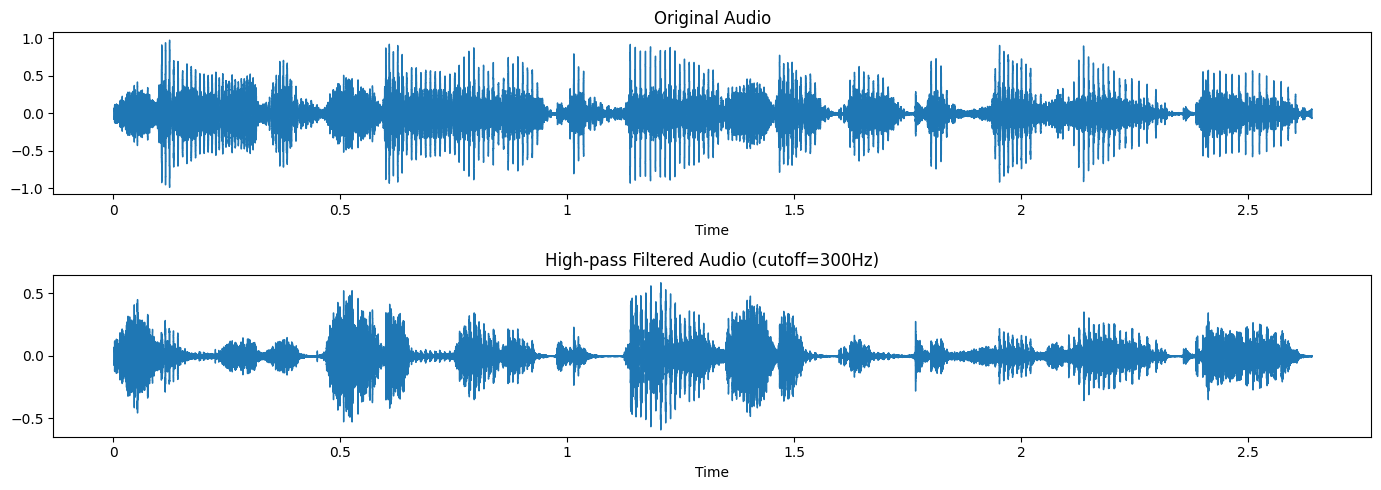

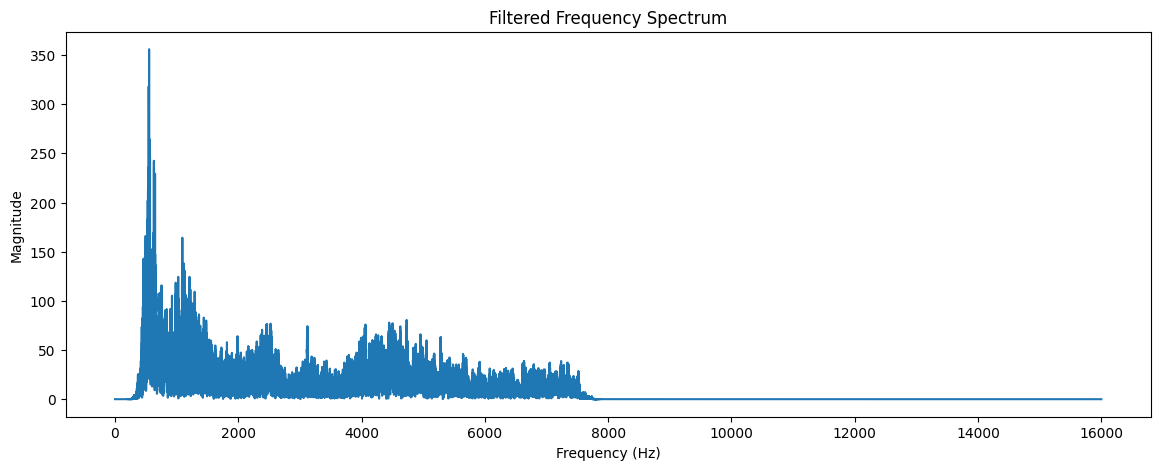

In [28]:
# 음성 파일 로드
audio_path = './train/AAIKZLBQ.ogg'
audio, sr = librosa.load(audio_path, sr=None)

# 고주파 필터링 적용
cutoff_frequency = 500  # 컷오프 주파수 설정
filtered_audio = high_pass_filter(audio, sr, cutoff=cutoff_frequency)

# 필터링 전후 파형 시각화
plt.figure(figsize=(14, 5))

plt.subplot(2, 1, 1)
librosa.display.waveshow(audio, sr=sr)
plt.title('Original Audio')

plt.subplot(2, 1, 2)
librosa.display.waveshow(filtered_audio, sr=sr)
plt.title('High-pass Filtered Audio (cutoff=300Hz)')

plt.tight_layout()
plt.show()

# 주파수 스펙트럼 시각화
fft_spectrum = np.fft.fft(filtered_audio)
frequencies = np.fft.fftfreq(len(fft_spectrum), 1/sr)

plt.figure(figsize=(14, 5))
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_spectrum)[:len(fft_spectrum)//2])
plt.title('Filtered Frequency Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

확연하게 magnitude가 줄은 것을 알 수 있음 (max 약 1800 -> 350)

## 전체 데이터에 대해 고주파 필터링 진행

In [ ]:
def process_directory(input_dir, output_dir, cutoff_frequency=300):
    """
    Process all audio files in the input directory with high-pass filter and save them to the output directory.
    
    Parameters:
    input_dir (str): Path to the input directory containing audio files
    output_dir (str): Path to the output directory to save filtered audio files
    cutoff_frequency (float): Cutoff frequency for the high-pass filter
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for filename in os.listdir(input_dir):
        if filename.endswith('.ogg'):
            file_path = os.path.join(input_dir, filename)
            audio, sr = librosa.load(file_path, sr=None)
            
            # Apply high-pass filter
            filtered_audio = high_pass_filter(audio, sr, cutoff=cutoff_frequency)
            
            # Save filtered audio
            output_file_path = os.path.join(output_dir, filename)
            sf.write(output_file_path, filtered_audio, sr, format='ogg')
            print(f"Processed and saved: {output_file_path}")

# Define paths
input_directory = './train'
output_directory = './preprocessed_train'

# Process the directory
process_directory(input_directory, output_directory, cutoff_frequency=500)

## 밴드 스톱 필터

In [2]:
import os
import librosa
import scipy.signal as signal
import numpy as np
import soundfile as sf
from tqdm import tqdm

def bandstop_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='bandstop')
    y = signal.lfilter(b, a, data)
    return y

def apply_filter_to_ogg_files(directory, lowcut, highcut, sr=16000, order=5):
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith('.ogg'):
            filepath = os.path.join(directory, filename)
            y, sr = librosa.load(filepath, sr=sr)
            filtered_y = bandstop_filter(y, lowcut, highcut, sr, order)
            output_filepath = os.path.join("./bandstop_unlabeled_data/", filename)
            sf.write(output_filepath, filtered_y, sr, format='OGG')
            print(f"Processed and saved: {output_filepath}")

# 예제 사용법
directory_path = './unlabeled_data'  # 오디오 파일이 있는 디렉토리 경로
apply_filter_to_ogg_files(directory_path, lowcut=1000, highcut=2000, sr=16000, order=5)

  1%|▏         | 17/1264 [00:00<00:15, 80.04it/s]

Processed and saved: ./bandstop_unlabeled_data/REUNJBGD.ogg
Processed and saved: ./bandstop_unlabeled_data/THRMCGCI.ogg
Processed and saved: ./bandstop_unlabeled_data/JLYEDYAD.ogg
Processed and saved: ./bandstop_unlabeled_data/KFZRLRYL.ogg
Processed and saved: ./bandstop_unlabeled_data/PBGXMVTG.ogg
Processed and saved: ./bandstop_unlabeled_data/XBKOUIAQ.ogg
Processed and saved: ./bandstop_unlabeled_data/INGEYZXH.ogg
Processed and saved: ./bandstop_unlabeled_data/ORJSBBPN.ogg
Processed and saved: ./bandstop_unlabeled_data/RGRAXYGD.ogg
Processed and saved: ./bandstop_unlabeled_data/QTXVITRK.ogg
Processed and saved: ./bandstop_unlabeled_data/OTURKWSP.ogg
Processed and saved: ./bandstop_unlabeled_data/NYNCIAPJ.ogg
Processed and saved: ./bandstop_unlabeled_data/OQARIUDV.ogg
Processed and saved: ./bandstop_unlabeled_data/NHZEYQPT.ogg
Processed and saved: ./bandstop_unlabeled_data/ZMNXMFZG.ogg
Processed and saved: ./bandstop_unlabeled_data/LUTHZNHA.ogg
Processed and saved: ./bandstop_unlabele

  3%|▎         | 35/1264 [00:00<00:14, 84.64it/s]

Processed and saved: ./bandstop_unlabeled_data/NIYEODKY.ogg
Processed and saved: ./bandstop_unlabeled_data/WSJPQJRY.ogg
Processed and saved: ./bandstop_unlabeled_data/LRPOWRJA.ogg
Processed and saved: ./bandstop_unlabeled_data/MTGGIUEM.ogg
Processed and saved: ./bandstop_unlabeled_data/KASORCPF.ogg
Processed and saved: ./bandstop_unlabeled_data/CDRFFEJE.ogg
Processed and saved: ./bandstop_unlabeled_data/GAMHXBDV.ogg
Processed and saved: ./bandstop_unlabeled_data/GJNSVOZO.ogg
Processed and saved: ./bandstop_unlabeled_data/XQMUMCUD.ogg
Processed and saved: ./bandstop_unlabeled_data/GWTGCMQE.ogg
Processed and saved: ./bandstop_unlabeled_data/FZYBTJRP.ogg
Processed and saved: ./bandstop_unlabeled_data/NBHKYFUL.ogg
Processed and saved: ./bandstop_unlabeled_data/VSWFIHLM.ogg
Processed and saved: ./bandstop_unlabeled_data/JIWSWPWX.ogg
Processed and saved: ./bandstop_unlabeled_data/DCPOOALC.ogg
Processed and saved: ./bandstop_unlabeled_data/IFINDAEM.ogg
Processed and saved: ./bandstop_unlabele

  3%|▎         | 44/1264 [00:00<00:14, 83.80it/s]

Processed and saved: ./bandstop_unlabeled_data/CNIFDEOD.ogg
Processed and saved: ./bandstop_unlabeled_data/BLEMJTLV.ogg
Processed and saved: ./bandstop_unlabeled_data/GJALMXWB.ogg
Processed and saved: ./bandstop_unlabeled_data/TBIKNBNP.ogg
Processed and saved: ./bandstop_unlabeled_data/WCUHQFGU.ogg
Processed and saved: ./bandstop_unlabeled_data/JVBGVXLW.ogg
Processed and saved: ./bandstop_unlabeled_data/ZLDYCTCZ.ogg
Processed and saved: ./bandstop_unlabeled_data/WYVDZWKK.ogg
Processed and saved: ./bandstop_unlabeled_data/NGZRWVWH.ogg
Processed and saved: ./bandstop_unlabeled_data/SSPOZGZS.ogg
Processed and saved: ./bandstop_unlabeled_data/CDYJODUP.ogg
Processed and saved: ./bandstop_unlabeled_data/EHVESDHD.ogg
Processed and saved: ./bandstop_unlabeled_data/ZXUNJOMW.ogg
Processed and saved: ./bandstop_unlabeled_data/LAKFPLNY.ogg
Processed and saved: ./bandstop_unlabeled_data/TVNLMXDQ.ogg
Processed and saved: ./bandstop_unlabeled_data/KJHXKAEU.ogg
Processed and saved: ./bandstop_unlabele

  5%|▍         | 62/1264 [00:00<00:14, 82.54it/s]

Processed and saved: ./bandstop_unlabeled_data/YLVROMCE.ogg
Processed and saved: ./bandstop_unlabeled_data/TAYAZIUA.ogg
Processed and saved: ./bandstop_unlabeled_data/QWFRSLOU.ogg
Processed and saved: ./bandstop_unlabeled_data/LPZJDZYR.ogg
Processed and saved: ./bandstop_unlabeled_data/RYTASCFH.ogg
Processed and saved: ./bandstop_unlabeled_data/CJKWHNPF.ogg
Processed and saved: ./bandstop_unlabeled_data/TXEQKDJS.ogg
Processed and saved: ./bandstop_unlabeled_data/BGKIYRUH.ogg
Processed and saved: ./bandstop_unlabeled_data/XIBFCQOV.ogg
Processed and saved: ./bandstop_unlabeled_data/YBENYCGL.ogg
Processed and saved: ./bandstop_unlabeled_data/COKMNIUL.ogg
Processed and saved: ./bandstop_unlabeled_data/FHWMTATO.ogg
Processed and saved: ./bandstop_unlabeled_data/OJOTBMHF.ogg
Processed and saved: ./bandstop_unlabeled_data/TXQSXDWD.ogg
Processed and saved: ./bandstop_unlabeled_data/ZDZKWULT.ogg
Processed and saved: ./bandstop_unlabeled_data/KGWWNKZY.ogg
Processed and saved: ./bandstop_unlabele

  6%|▋         | 81/1264 [00:00<00:13, 85.88it/s]

Processed and saved: ./bandstop_unlabeled_data/WXKMXAUN.ogg
Processed and saved: ./bandstop_unlabeled_data/KXAYRLGU.ogg
Processed and saved: ./bandstop_unlabeled_data/GAHABHQR.ogg
Processed and saved: ./bandstop_unlabeled_data/PHPDEUYI.ogg
Processed and saved: ./bandstop_unlabeled_data/IBOTHTXZ.ogg
Processed and saved: ./bandstop_unlabeled_data/GZCQSSDZ.ogg
Processed and saved: ./bandstop_unlabeled_data/RBQHCKTW.ogg
Processed and saved: ./bandstop_unlabeled_data/ZNKETQPG.ogg
Processed and saved: ./bandstop_unlabeled_data/QLTOQPBJ.ogg
Processed and saved: ./bandstop_unlabeled_data/JBLYFFWS.ogg
Processed and saved: ./bandstop_unlabeled_data/GKXYVVED.ogg
Processed and saved: ./bandstop_unlabeled_data/XNTMGSZN.ogg
Processed and saved: ./bandstop_unlabeled_data/ZXYKTQGY.ogg
Processed and saved: ./bandstop_unlabeled_data/OKVDHOUB.ogg
Processed and saved: ./bandstop_unlabeled_data/VPAEVJYS.ogg
Processed and saved: ./bandstop_unlabeled_data/GRMGRYQJ.ogg
Processed and saved: ./bandstop_unlabele

  8%|▊         | 99/1264 [00:01<00:13, 84.73it/s]

Processed and saved: ./bandstop_unlabeled_data/OEDFTEDI.ogg
Processed and saved: ./bandstop_unlabeled_data/NYPNWMLR.ogg
Processed and saved: ./bandstop_unlabeled_data/YAUSXGLQ.ogg
Processed and saved: ./bandstop_unlabeled_data/JFPLJNLW.ogg
Processed and saved: ./bandstop_unlabeled_data/JJVIPVSL.ogg
Processed and saved: ./bandstop_unlabeled_data/YEIJTZNV.ogg
Processed and saved: ./bandstop_unlabeled_data/BCFCIBHG.ogg
Processed and saved: ./bandstop_unlabeled_data/FSTFASXM.ogg
Processed and saved: ./bandstop_unlabeled_data/IIDIUQFC.ogg
Processed and saved: ./bandstop_unlabeled_data/JFTFXXDO.ogg
Processed and saved: ./bandstop_unlabeled_data/QVKIUYTJ.ogg
Processed and saved: ./bandstop_unlabeled_data/ZGZXEYNV.ogg
Processed and saved: ./bandstop_unlabeled_data/BCDWJPME.ogg
Processed and saved: ./bandstop_unlabeled_data/EBMOELPP.ogg
Processed and saved: ./bandstop_unlabeled_data/DSPHZTAQ.ogg
Processed and saved: ./bandstop_unlabeled_data/POVVFBUC.ogg
Processed and saved: ./bandstop_unlabele

  9%|▉         | 117/1264 [00:01<00:13, 85.74it/s]

Processed and saved: ./bandstop_unlabeled_data/QUTOBGQX.ogg
Processed and saved: ./bandstop_unlabeled_data/XZRPLXEO.ogg
Processed and saved: ./bandstop_unlabeled_data/RVBLCNEE.ogg
Processed and saved: ./bandstop_unlabeled_data/KHENDSWL.ogg
Processed and saved: ./bandstop_unlabeled_data/SHZGSQDY.ogg
Processed and saved: ./bandstop_unlabeled_data/GQTFQBPO.ogg
Processed and saved: ./bandstop_unlabeled_data/MVCIRPPL.ogg
Processed and saved: ./bandstop_unlabeled_data/UNHXSLSM.ogg
Processed and saved: ./bandstop_unlabeled_data/RHEQPQXS.ogg
Processed and saved: ./bandstop_unlabeled_data/SHEIKVRJ.ogg
Processed and saved: ./bandstop_unlabeled_data/GSYDRSKJ.ogg
Processed and saved: ./bandstop_unlabeled_data/SRTDXYFG.ogg
Processed and saved: ./bandstop_unlabeled_data/IYNHYHPR.ogg
Processed and saved: ./bandstop_unlabeled_data/YDSDZDSZ.ogg
Processed and saved: ./bandstop_unlabeled_data/ODSHXROU.ogg
Processed and saved: ./bandstop_unlabeled_data/CWZMBJFT.ogg
Processed and saved: ./bandstop_unlabele

 11%|█         | 135/1264 [00:01<00:13, 85.44it/s]

Processed and saved: ./bandstop_unlabeled_data/XEJZTGZZ.ogg
Processed and saved: ./bandstop_unlabeled_data/VUUOXGAW.ogg
Processed and saved: ./bandstop_unlabeled_data/YWPQBQZR.ogg
Processed and saved: ./bandstop_unlabeled_data/KBLSQOOI.ogg
Processed and saved: ./bandstop_unlabeled_data/YTDSJXFL.ogg
Processed and saved: ./bandstop_unlabeled_data/NKYWTGQX.ogg
Processed and saved: ./bandstop_unlabeled_data/KJMWRCRP.ogg
Processed and saved: ./bandstop_unlabeled_data/VDSXPLHZ.ogg
Processed and saved: ./bandstop_unlabeled_data/IADJEMLY.ogg
Processed and saved: ./bandstop_unlabeled_data/SHJCJLVW.ogg
Processed and saved: ./bandstop_unlabeled_data/XHGGRLEQ.ogg
Processed and saved: ./bandstop_unlabeled_data/HLFIRNGP.ogg
Processed and saved: ./bandstop_unlabeled_data/WTTGCZHL.ogg
Processed and saved: ./bandstop_unlabeled_data/LKWBGYRD.ogg
Processed and saved: ./bandstop_unlabeled_data/ILBYGOUW.ogg
Processed and saved: ./bandstop_unlabeled_data/PBUPLZLB.ogg
Processed and saved: ./bandstop_unlabele

 12%|█▏        | 153/1264 [00:01<00:13, 84.00it/s]

Processed and saved: ./bandstop_unlabeled_data/ADUNDKGO.ogg
Processed and saved: ./bandstop_unlabeled_data/FLJWGDBW.ogg
Processed and saved: ./bandstop_unlabeled_data/TOPMMKZN.ogg
Processed and saved: ./bandstop_unlabeled_data/KOREVWOV.ogg
Processed and saved: ./bandstop_unlabeled_data/LIZSRBMN.ogg
Processed and saved: ./bandstop_unlabeled_data/DDHHOTDZ.ogg
Processed and saved: ./bandstop_unlabeled_data/GHDNCLPX.ogg
Processed and saved: ./bandstop_unlabeled_data/MYIASZFK.ogg
Processed and saved: ./bandstop_unlabeled_data/ACHLOQRM.ogg
Processed and saved: ./bandstop_unlabeled_data/PSOAJUSA.ogg
Processed and saved: ./bandstop_unlabeled_data/EMXPKCYK.ogg
Processed and saved: ./bandstop_unlabeled_data/WBOEFNHI.ogg
Processed and saved: ./bandstop_unlabeled_data/IPKQNMZA.ogg
Processed and saved: ./bandstop_unlabeled_data/TCTAOHMS.ogg
Processed and saved: ./bandstop_unlabeled_data/RRHAWKEA.ogg
Processed and saved: ./bandstop_unlabeled_data/WWFFPFDJ.ogg
Processed and saved: ./bandstop_unlabele

 14%|█▎        | 171/1264 [00:02<00:13, 82.36it/s]

Processed and saved: ./bandstop_unlabeled_data/MLJTNFDQ.ogg
Processed and saved: ./bandstop_unlabeled_data/UMDTIYYV.ogg
Processed and saved: ./bandstop_unlabeled_data/AMXQVODZ.ogg
Processed and saved: ./bandstop_unlabeled_data/OBMLSPNB.ogg
Processed and saved: ./bandstop_unlabeled_data/PHPOPHCK.ogg
Processed and saved: ./bandstop_unlabeled_data/SAECJYDH.ogg
Processed and saved: ./bandstop_unlabeled_data/BAGIDGJN.ogg
Processed and saved: ./bandstop_unlabeled_data/ENXOOATA.ogg
Processed and saved: ./bandstop_unlabeled_data/MDJATPTY.ogg
Processed and saved: ./bandstop_unlabeled_data/DFMIHMUJ.ogg
Processed and saved: ./bandstop_unlabeled_data/XLXWYAPT.ogg
Processed and saved: ./bandstop_unlabeled_data/PLIZREEO.ogg
Processed and saved: ./bandstop_unlabeled_data/JSMQROAY.ogg
Processed and saved: ./bandstop_unlabeled_data/VDBDYXBQ.ogg
Processed and saved: ./bandstop_unlabeled_data/KICLJQSS.ogg
Processed and saved: ./bandstop_unlabeled_data/KDEXQYRQ.ogg
Processed and saved: ./bandstop_unlabele

 15%|█▍        | 189/1264 [00:02<00:12, 83.38it/s]

Processed and saved: ./bandstop_unlabeled_data/ECTTKUBH.ogg
Processed and saved: ./bandstop_unlabeled_data/AQDBKHGT.ogg
Processed and saved: ./bandstop_unlabeled_data/WOJPSVFA.ogg
Processed and saved: ./bandstop_unlabeled_data/YRBBCABE.ogg
Processed and saved: ./bandstop_unlabeled_data/RRMCECFJ.ogg
Processed and saved: ./bandstop_unlabeled_data/WGTUSGFX.ogg
Processed and saved: ./bandstop_unlabeled_data/JIBHPNUW.ogg
Processed and saved: ./bandstop_unlabeled_data/FQTNHXBZ.ogg
Processed and saved: ./bandstop_unlabeled_data/FJPFTZKT.ogg
Processed and saved: ./bandstop_unlabeled_data/ALJGVRMD.ogg
Processed and saved: ./bandstop_unlabeled_data/DXBWNPAU.ogg
Processed and saved: ./bandstop_unlabeled_data/EQDXLTUN.ogg
Processed and saved: ./bandstop_unlabeled_data/HVOIHZOP.ogg
Processed and saved: ./bandstop_unlabeled_data/KGEDIUFD.ogg
Processed and saved: ./bandstop_unlabeled_data/AHHFPCPB.ogg
Processed and saved: ./bandstop_unlabeled_data/HOTNUVAK.ogg
Processed and saved: ./bandstop_unlabele

 16%|█▋        | 207/1264 [00:02<00:12, 84.18it/s]

Processed and saved: ./bandstop_unlabeled_data/MVHJIJXZ.ogg
Processed and saved: ./bandstop_unlabeled_data/QPCHFRYD.ogg
Processed and saved: ./bandstop_unlabeled_data/AJHEAGQS.ogg
Processed and saved: ./bandstop_unlabeled_data/NSAMCCBY.ogg
Processed and saved: ./bandstop_unlabeled_data/SJZSHKLC.ogg
Processed and saved: ./bandstop_unlabeled_data/IUXBMNYC.ogg
Processed and saved: ./bandstop_unlabeled_data/AECNJFCE.ogg
Processed and saved: ./bandstop_unlabeled_data/NTEKNCRH.ogg
Processed and saved: ./bandstop_unlabeled_data/ECDZJODQ.ogg
Processed and saved: ./bandstop_unlabeled_data/KVFHECAA.ogg
Processed and saved: ./bandstop_unlabeled_data/EEBSPLPD.ogg
Processed and saved: ./bandstop_unlabeled_data/BOIQBIAZ.ogg
Processed and saved: ./bandstop_unlabeled_data/NRVZDKEQ.ogg
Processed and saved: ./bandstop_unlabeled_data/NSZZBACI.ogg
Processed and saved: ./bandstop_unlabeled_data/XJQCCIWQ.ogg
Processed and saved: ./bandstop_unlabeled_data/ZHGOVUQF.ogg
Processed and saved: ./bandstop_unlabele

 18%|█▊        | 226/1264 [00:02<00:12, 85.96it/s]

Processed and saved: ./bandstop_unlabeled_data/OYHDSZWN.ogg
Processed and saved: ./bandstop_unlabeled_data/QHRMKPDD.ogg
Processed and saved: ./bandstop_unlabeled_data/UDLKVDEU.ogg
Processed and saved: ./bandstop_unlabeled_data/XHOIZFTW.ogg
Processed and saved: ./bandstop_unlabeled_data/TQHHACSB.ogg
Processed and saved: ./bandstop_unlabeled_data/OTSEWPGS.ogg
Processed and saved: ./bandstop_unlabeled_data/MNQVYYNY.ogg
Processed and saved: ./bandstop_unlabeled_data/DAIDWUBN.ogg
Processed and saved: ./bandstop_unlabeled_data/WJECKUDC.ogg
Processed and saved: ./bandstop_unlabeled_data/HOCJQNIS.ogg
Processed and saved: ./bandstop_unlabeled_data/XSSKPJDE.ogg
Processed and saved: ./bandstop_unlabeled_data/LVPYISEG.ogg
Processed and saved: ./bandstop_unlabeled_data/RYCIFDAI.ogg
Processed and saved: ./bandstop_unlabeled_data/KYRIDRZW.ogg
Processed and saved: ./bandstop_unlabeled_data/PRVSFTER.ogg
Processed and saved: ./bandstop_unlabeled_data/NZSFPFUB.ogg
Processed and saved: ./bandstop_unlabele

 19%|█▉        | 244/1264 [00:02<00:11, 85.41it/s]

Processed and saved: ./bandstop_unlabeled_data/DJUHFZOJ.ogg
Processed and saved: ./bandstop_unlabeled_data/ZJEIQIGZ.ogg
Processed and saved: ./bandstop_unlabeled_data/WWOXIYOI.ogg
Processed and saved: ./bandstop_unlabeled_data/ACRWFOFF.ogg
Processed and saved: ./bandstop_unlabeled_data/WSXDXKQL.ogg
Processed and saved: ./bandstop_unlabeled_data/IUDSSFBV.ogg
Processed and saved: ./bandstop_unlabeled_data/RFEFDKBU.ogg
Processed and saved: ./bandstop_unlabeled_data/OPKNYYQY.ogg
Processed and saved: ./bandstop_unlabeled_data/QGIGLHAF.ogg
Processed and saved: ./bandstop_unlabeled_data/DTZJEVNP.ogg
Processed and saved: ./bandstop_unlabeled_data/VMETCYHS.ogg
Processed and saved: ./bandstop_unlabeled_data/UJYAAVBL.ogg
Processed and saved: ./bandstop_unlabeled_data/FNVWSHLS.ogg
Processed and saved: ./bandstop_unlabeled_data/MGJJSNOS.ogg
Processed and saved: ./bandstop_unlabeled_data/YRPRXHRW.ogg
Processed and saved: ./bandstop_unlabeled_data/WFTMRHBK.ogg
Processed and saved: ./bandstop_unlabele

 21%|██        | 262/1264 [00:03<00:11, 85.30it/s]

Processed and saved: ./bandstop_unlabeled_data/YEDWIUCT.ogg
Processed and saved: ./bandstop_unlabeled_data/VZTJDZBL.ogg
Processed and saved: ./bandstop_unlabeled_data/AMXTBJZA.ogg
Processed and saved: ./bandstop_unlabeled_data/GLYMAWLA.ogg
Processed and saved: ./bandstop_unlabeled_data/CRNHAOER.ogg
Processed and saved: ./bandstop_unlabeled_data/FNJTLSMB.ogg
Processed and saved: ./bandstop_unlabeled_data/THGQZWCK.ogg
Processed and saved: ./bandstop_unlabeled_data/KCGJSRPW.ogg
Processed and saved: ./bandstop_unlabeled_data/VBRHJQJK.ogg
Processed and saved: ./bandstop_unlabeled_data/WADMEBYX.ogg
Processed and saved: ./bandstop_unlabeled_data/XBUSHANN.ogg
Processed and saved: ./bandstop_unlabeled_data/KVNWGQGA.ogg
Processed and saved: ./bandstop_unlabeled_data/DCJQOSBL.ogg
Processed and saved: ./bandstop_unlabeled_data/NBPGNAJX.ogg
Processed and saved: ./bandstop_unlabeled_data/DPVAXZQH.ogg
Processed and saved: ./bandstop_unlabeled_data/ARPMVOPT.ogg
Processed and saved: ./bandstop_unlabele

 22%|██▏       | 280/1264 [00:03<00:11, 85.40it/s]

Processed and saved: ./bandstop_unlabeled_data/XJQHMDUA.ogg
Processed and saved: ./bandstop_unlabeled_data/DNOEWZFW.ogg
Processed and saved: ./bandstop_unlabeled_data/YFISKBJU.ogg
Processed and saved: ./bandstop_unlabeled_data/BHROXTWO.ogg
Processed and saved: ./bandstop_unlabeled_data/NLQFKOFA.ogg
Processed and saved: ./bandstop_unlabeled_data/MPDHVRSG.ogg
Processed and saved: ./bandstop_unlabeled_data/LSXPWRVP.ogg
Processed and saved: ./bandstop_unlabeled_data/ZLPPVQBR.ogg
Processed and saved: ./bandstop_unlabeled_data/NBGUAWIC.ogg
Processed and saved: ./bandstop_unlabeled_data/YAXGXNBW.ogg
Processed and saved: ./bandstop_unlabeled_data/SUDIDDKP.ogg
Processed and saved: ./bandstop_unlabeled_data/QNJOEQWB.ogg
Processed and saved: ./bandstop_unlabeled_data/YOWPYBMM.ogg
Processed and saved: ./bandstop_unlabeled_data/YNZGWPZH.ogg
Processed and saved: ./bandstop_unlabeled_data/ANSCGYZM.ogg
Processed and saved: ./bandstop_unlabeled_data/QUBYBTWN.ogg
Processed and saved: ./bandstop_unlabele

 24%|██▎       | 298/1264 [00:03<00:11, 86.41it/s]

Processed and saved: ./bandstop_unlabeled_data/AJJXYNBW.ogg
Processed and saved: ./bandstop_unlabeled_data/FXFCMSAD.ogg
Processed and saved: ./bandstop_unlabeled_data/POGRCZVS.ogg
Processed and saved: ./bandstop_unlabeled_data/AKABYUBN.ogg
Processed and saved: ./bandstop_unlabeled_data/ELZUIYTM.ogg
Processed and saved: ./bandstop_unlabeled_data/ULGPQONR.ogg
Processed and saved: ./bandstop_unlabeled_data/JKZHJRAI.ogg
Processed and saved: ./bandstop_unlabeled_data/DXLMUNZC.ogg
Processed and saved: ./bandstop_unlabeled_data/IPJWPCQV.ogg
Processed and saved: ./bandstop_unlabeled_data/HGLFCANU.ogg
Processed and saved: ./bandstop_unlabeled_data/PVSIGIQW.ogg
Processed and saved: ./bandstop_unlabeled_data/HYBPWGSC.ogg
Processed and saved: ./bandstop_unlabeled_data/UMCOBOUZ.ogg
Processed and saved: ./bandstop_unlabeled_data/FVPBUBIT.ogg
Processed and saved: ./bandstop_unlabeled_data/MXICXSDW.ogg
Processed and saved: ./bandstop_unlabeled_data/AHJELUZU.ogg
Processed and saved: ./bandstop_unlabele

 24%|██▍       | 307/1264 [00:03<00:11, 85.94it/s]

Processed and saved: ./bandstop_unlabeled_data/GXGDFBBN.ogg
Processed and saved: ./bandstop_unlabeled_data/CQTUDJFF.ogg
Processed and saved: ./bandstop_unlabeled_data/JOJVXUBD.ogg
Processed and saved: ./bandstop_unlabeled_data/CXOAHNUG.ogg
Processed and saved: ./bandstop_unlabeled_data/PQIPWQZD.ogg
Processed and saved: ./bandstop_unlabeled_data/NLOOIQFW.ogg
Processed and saved: ./bandstop_unlabeled_data/TWLIWHRP.ogg
Processed and saved: ./bandstop_unlabeled_data/EEHRMHBK.ogg
Processed and saved: ./bandstop_unlabeled_data/GYFELSTN.ogg
Processed and saved: ./bandstop_unlabeled_data/NKQOXRJM.ogg
Processed and saved: ./bandstop_unlabeled_data/XZYRQUYF.ogg
Processed and saved: ./bandstop_unlabeled_data/JYWIKLWO.ogg
Processed and saved: ./bandstop_unlabeled_data/TUHLVKNN.ogg
Processed and saved: ./bandstop_unlabeled_data/CHRYCMCY.ogg
Processed and saved: ./bandstop_unlabeled_data/OQXWGATH.ogg
Processed and saved: ./bandstop_unlabeled_data/LBMQAKLF.ogg
Processed and saved: ./bandstop_unlabele

 26%|██▌       | 325/1264 [00:03<00:11, 84.02it/s]

Processed and saved: ./bandstop_unlabeled_data/BTSMKSYG.ogg
Processed and saved: ./bandstop_unlabeled_data/WCKQGVPZ.ogg
Processed and saved: ./bandstop_unlabeled_data/DZVXKMDC.ogg
Processed and saved: ./bandstop_unlabeled_data/MINKXHJD.ogg
Processed and saved: ./bandstop_unlabeled_data/QCZXQJWY.ogg
Processed and saved: ./bandstop_unlabeled_data/IALXTEHF.ogg
Processed and saved: ./bandstop_unlabeled_data/PUJOQDWL.ogg
Processed and saved: ./bandstop_unlabeled_data/IJCKSDQM.ogg
Processed and saved: ./bandstop_unlabeled_data/ZROOPFQL.ogg
Processed and saved: ./bandstop_unlabeled_data/XJQJLGLJ.ogg
Processed and saved: ./bandstop_unlabeled_data/DTAKNIPW.ogg
Processed and saved: ./bandstop_unlabeled_data/IXWQHCKE.ogg
Processed and saved: ./bandstop_unlabeled_data/OKDVCSNL.ogg
Processed and saved: ./bandstop_unlabeled_data/TOHRYJLD.ogg
Processed and saved: ./bandstop_unlabeled_data/VIFMREDQ.ogg
Processed and saved: ./bandstop_unlabeled_data/YJXRGURP.ogg
Processed and saved: ./bandstop_unlabele

 27%|██▋       | 343/1264 [00:04<00:10, 84.92it/s]

Processed and saved: ./bandstop_unlabeled_data/PWEWLNQC.ogg
Processed and saved: ./bandstop_unlabeled_data/YMLXTVAL.ogg
Processed and saved: ./bandstop_unlabeled_data/SBWBNZKJ.ogg
Processed and saved: ./bandstop_unlabeled_data/OOGOXIWO.ogg
Processed and saved: ./bandstop_unlabeled_data/TUCMOVHG.ogg
Processed and saved: ./bandstop_unlabeled_data/LYXZFYVC.ogg
Processed and saved: ./bandstop_unlabeled_data/YEVGAUSC.ogg
Processed and saved: ./bandstop_unlabeled_data/PPEMPNAT.ogg
Processed and saved: ./bandstop_unlabeled_data/HOROHFDF.ogg
Processed and saved: ./bandstop_unlabeled_data/NCPMJOFT.ogg
Processed and saved: ./bandstop_unlabeled_data/DQKZHOWE.ogg
Processed and saved: ./bandstop_unlabeled_data/OVONOESL.ogg
Processed and saved: ./bandstop_unlabeled_data/IBCWMYXI.ogg
Processed and saved: ./bandstop_unlabeled_data/KULVQYQG.ogg
Processed and saved: ./bandstop_unlabeled_data/KLTLDHIZ.ogg
Processed and saved: ./bandstop_unlabeled_data/ILFKCLXA.ogg
Processed and saved: ./bandstop_unlabele

 29%|██▊       | 361/1264 [00:04<00:10, 85.79it/s]

Processed and saved: ./bandstop_unlabeled_data/ZACCJWMV.ogg
Processed and saved: ./bandstop_unlabeled_data/KUYXJZCW.ogg
Processed and saved: ./bandstop_unlabeled_data/AUQVOJUI.ogg
Processed and saved: ./bandstop_unlabeled_data/OXZAUYFZ.ogg
Processed and saved: ./bandstop_unlabeled_data/TICLCHFV.ogg
Processed and saved: ./bandstop_unlabeled_data/JEZAIJYK.ogg
Processed and saved: ./bandstop_unlabeled_data/HAJICFQI.ogg
Processed and saved: ./bandstop_unlabeled_data/FDPUIRRS.ogg
Processed and saved: ./bandstop_unlabeled_data/YCBGJALR.ogg
Processed and saved: ./bandstop_unlabeled_data/JOGBUBXO.ogg
Processed and saved: ./bandstop_unlabeled_data/DTPQOWVM.ogg
Processed and saved: ./bandstop_unlabeled_data/TJYECIZJ.ogg
Processed and saved: ./bandstop_unlabeled_data/KQCWDURX.ogg
Processed and saved: ./bandstop_unlabeled_data/UESQQGDA.ogg
Processed and saved: ./bandstop_unlabeled_data/KJZSWRJD.ogg
Processed and saved: ./bandstop_unlabeled_data/MZPOFBOK.ogg
Processed and saved: ./bandstop_unlabele

 30%|███       | 380/1264 [00:04<00:10, 85.21it/s]

Processed and saved: ./bandstop_unlabeled_data/OFFVDGWF.ogg
Processed and saved: ./bandstop_unlabeled_data/ZNKNSNKR.ogg
Processed and saved: ./bandstop_unlabeled_data/SGXUUGQO.ogg
Processed and saved: ./bandstop_unlabeled_data/ROURWWII.ogg
Processed and saved: ./bandstop_unlabeled_data/ZNVUXGCN.ogg
Processed and saved: ./bandstop_unlabeled_data/ZJMIEUOH.ogg
Processed and saved: ./bandstop_unlabeled_data/FHCSIIYL.ogg
Processed and saved: ./bandstop_unlabeled_data/KDOMYALU.ogg
Processed and saved: ./bandstop_unlabeled_data/LLXIETSA.ogg
Processed and saved: ./bandstop_unlabeled_data/QMFDVPMH.ogg
Processed and saved: ./bandstop_unlabeled_data/ODEFIVJF.ogg
Processed and saved: ./bandstop_unlabeled_data/IBJPECCC.ogg
Processed and saved: ./bandstop_unlabeled_data/BZHMQAET.ogg
Processed and saved: ./bandstop_unlabeled_data/VPCSJUBT.ogg
Processed and saved: ./bandstop_unlabeled_data/ZCSKRJDI.ogg
Processed and saved: ./bandstop_unlabeled_data/QASOKUQY.ogg
Processed and saved: ./bandstop_unlabele

 31%|███▏      | 398/1264 [00:04<00:11, 77.14it/s]

Processed and saved: ./bandstop_unlabeled_data/XLAWGDSM.ogg
Processed and saved: ./bandstop_unlabeled_data/TLKMGRBK.ogg
Processed and saved: ./bandstop_unlabeled_data/KFWLWHKS.ogg
Processed and saved: ./bandstop_unlabeled_data/KGWASWFK.ogg
Processed and saved: ./bandstop_unlabeled_data/RIHWMUXF.ogg
Processed and saved: ./bandstop_unlabeled_data/HXSZIWSP.ogg
Processed and saved: ./bandstop_unlabeled_data/NSESXSTN.ogg
Processed and saved: ./bandstop_unlabeled_data/LEDYXCFH.ogg
Processed and saved: ./bandstop_unlabeled_data/AQUNMIMS.ogg
Processed and saved: ./bandstop_unlabeled_data/JQZTXZMK.ogg
Processed and saved: ./bandstop_unlabeled_data/PQCORBDE.ogg
Processed and saved: ./bandstop_unlabeled_data/LZXCMHCR.ogg
Processed and saved: ./bandstop_unlabeled_data/ORTEUJMS.ogg
Processed and saved: ./bandstop_unlabeled_data/TGPTWEHE.ogg
Processed and saved: ./bandstop_unlabeled_data/RCIKRYFA.ogg


 33%|███▎      | 416/1264 [00:04<00:10, 79.87it/s]

Processed and saved: ./bandstop_unlabeled_data/FDVRIMQW.ogg
Processed and saved: ./bandstop_unlabeled_data/DOIDRPLU.ogg
Processed and saved: ./bandstop_unlabeled_data/DPWHKACT.ogg
Processed and saved: ./bandstop_unlabeled_data/JWWFZFKA.ogg
Processed and saved: ./bandstop_unlabeled_data/UHSOKIAU.ogg
Processed and saved: ./bandstop_unlabeled_data/NSNTXKWK.ogg
Processed and saved: ./bandstop_unlabeled_data/VYLGQGDS.ogg
Processed and saved: ./bandstop_unlabeled_data/JXRSZXDH.ogg
Processed and saved: ./bandstop_unlabeled_data/JWUGCLEB.ogg
Processed and saved: ./bandstop_unlabeled_data/QBHCRSZO.ogg
Processed and saved: ./bandstop_unlabeled_data/RMOGMHOZ.ogg
Processed and saved: ./bandstop_unlabeled_data/XPCIUBPA.ogg
Processed and saved: ./bandstop_unlabeled_data/GEXSABJB.ogg
Processed and saved: ./bandstop_unlabeled_data/AJEUSDFU.ogg
Processed and saved: ./bandstop_unlabeled_data/QJXINRKV.ogg
Processed and saved: ./bandstop_unlabeled_data/OMCTSUKG.ogg
Processed and saved: ./bandstop_unlabele

 34%|███▍      | 434/1264 [00:05<00:10, 81.83it/s]

Processed and saved: ./bandstop_unlabeled_data/CNWDAGNX.ogg
Processed and saved: ./bandstop_unlabeled_data/ZDNYPFVB.ogg
Processed and saved: ./bandstop_unlabeled_data/OTFLDBGR.ogg
Processed and saved: ./bandstop_unlabeled_data/ZQYZMISE.ogg
Processed and saved: ./bandstop_unlabeled_data/CJQAOSSK.ogg
Processed and saved: ./bandstop_unlabeled_data/MABVBTQT.ogg
Processed and saved: ./bandstop_unlabeled_data/FIGMYGFN.ogg
Processed and saved: ./bandstop_unlabeled_data/GQAIBAAT.ogg
Processed and saved: ./bandstop_unlabeled_data/CUZLUIFD.ogg
Processed and saved: ./bandstop_unlabeled_data/MTSIFVPJ.ogg
Processed and saved: ./bandstop_unlabeled_data/RGVLGGRM.ogg
Processed and saved: ./bandstop_unlabeled_data/BSCIKAWT.ogg
Processed and saved: ./bandstop_unlabeled_data/CMOSIWTF.ogg
Processed and saved: ./bandstop_unlabeled_data/QUDWUSNN.ogg
Processed and saved: ./bandstop_unlabeled_data/SIXIPUNR.ogg
Processed and saved: ./bandstop_unlabeled_data/RCFDTKBB.ogg
Processed and saved: ./bandstop_unlabele

 35%|███▌      | 443/1264 [00:05<00:09, 82.13it/s]

Processed and saved: ./bandstop_unlabeled_data/QEIQBQFY.ogg
Processed and saved: ./bandstop_unlabeled_data/QMFSCJJR.ogg
Processed and saved: ./bandstop_unlabeled_data/ZVWEFDBU.ogg
Processed and saved: ./bandstop_unlabeled_data/YBQPDAHI.ogg
Processed and saved: ./bandstop_unlabeled_data/JYTWTASL.ogg
Processed and saved: ./bandstop_unlabeled_data/UIFEOQVN.ogg
Processed and saved: ./bandstop_unlabeled_data/WIISOCGE.ogg
Processed and saved: ./bandstop_unlabeled_data/HUCVDEKS.ogg
Processed and saved: ./bandstop_unlabeled_data/HZIBEGFG.ogg
Processed and saved: ./bandstop_unlabeled_data/WBUDGKCJ.ogg
Processed and saved: ./bandstop_unlabeled_data/XKZIOIIT.ogg
Processed and saved: ./bandstop_unlabeled_data/QEEXCCOE.ogg
Processed and saved: ./bandstop_unlabeled_data/JRCHHZZI.ogg
Processed and saved: ./bandstop_unlabeled_data/HNNXANLW.ogg
Processed and saved: ./bandstop_unlabeled_data/EELGHDND.ogg
Processed and saved: ./bandstop_unlabeled_data/QCQSAFOB.ogg
Processed and saved: ./bandstop_unlabele

 36%|███▋      | 461/1264 [00:05<00:09, 80.77it/s]

Processed and saved: ./bandstop_unlabeled_data/XRHESRXU.ogg
Processed and saved: ./bandstop_unlabeled_data/RPBFQTGX.ogg
Processed and saved: ./bandstop_unlabeled_data/BQOLTCYU.ogg
Processed and saved: ./bandstop_unlabeled_data/EYSPLZVZ.ogg
Processed and saved: ./bandstop_unlabeled_data/PBQLWBJU.ogg
Processed and saved: ./bandstop_unlabeled_data/QZXTJOCD.ogg
Processed and saved: ./bandstop_unlabeled_data/QUKFZKAO.ogg
Processed and saved: ./bandstop_unlabeled_data/JYJAGTWP.ogg
Processed and saved: ./bandstop_unlabeled_data/NNBAYXXJ.ogg
Processed and saved: ./bandstop_unlabeled_data/UQNTZSCU.ogg
Processed and saved: ./bandstop_unlabeled_data/GHRKKDYK.ogg
Processed and saved: ./bandstop_unlabeled_data/WCWPPDLO.ogg
Processed and saved: ./bandstop_unlabeled_data/CZRFNJLN.ogg
Processed and saved: ./bandstop_unlabeled_data/WFEEYCML.ogg
Processed and saved: ./bandstop_unlabeled_data/TSEVXBIN.ogg
Processed and saved: ./bandstop_unlabeled_data/VRAPFXUQ.ogg


 38%|███▊      | 479/1264 [00:05<00:09, 81.00it/s]

Processed and saved: ./bandstop_unlabeled_data/MPSEDVYB.ogg
Processed and saved: ./bandstop_unlabeled_data/SFULDDXA.ogg
Processed and saved: ./bandstop_unlabeled_data/BUUQXSVT.ogg
Processed and saved: ./bandstop_unlabeled_data/VNJDMMGL.ogg
Processed and saved: ./bandstop_unlabeled_data/PMGUPBSF.ogg
Processed and saved: ./bandstop_unlabeled_data/DPPZJCDR.ogg
Processed and saved: ./bandstop_unlabeled_data/KOOVMORA.ogg
Processed and saved: ./bandstop_unlabeled_data/CSRUHXNM.ogg
Processed and saved: ./bandstop_unlabeled_data/ESHIAJHN.ogg
Processed and saved: ./bandstop_unlabeled_data/PLOHUXLA.ogg
Processed and saved: ./bandstop_unlabeled_data/KRAYRJEN.ogg
Processed and saved: ./bandstop_unlabeled_data/AWUVZAFX.ogg
Processed and saved: ./bandstop_unlabeled_data/LBQYZRZN.ogg
Processed and saved: ./bandstop_unlabeled_data/DIQPWIFI.ogg
Processed and saved: ./bandstop_unlabeled_data/GWTGLGDQ.ogg
Processed and saved: ./bandstop_unlabeled_data/INRLOCJK.ogg
Processed and saved: ./bandstop_unlabele

 39%|███▉      | 498/1264 [00:05<00:09, 83.46it/s]

Processed and saved: ./bandstop_unlabeled_data/LEDMOZVK.ogg
Processed and saved: ./bandstop_unlabeled_data/BEDSXPNV.ogg
Processed and saved: ./bandstop_unlabeled_data/PDNQYKNB.ogg
Processed and saved: ./bandstop_unlabeled_data/MOWOJPZT.ogg
Processed and saved: ./bandstop_unlabeled_data/ODVDJAMA.ogg
Processed and saved: ./bandstop_unlabeled_data/TXOOUEQY.ogg
Processed and saved: ./bandstop_unlabeled_data/DJFEBRQI.ogg
Processed and saved: ./bandstop_unlabeled_data/IMHXBPNV.ogg
Processed and saved: ./bandstop_unlabeled_data/HCLUUWRT.ogg
Processed and saved: ./bandstop_unlabeled_data/IDBHSHLP.ogg
Processed and saved: ./bandstop_unlabeled_data/ASAPHKOM.ogg
Processed and saved: ./bandstop_unlabeled_data/VUVLVQYG.ogg
Processed and saved: ./bandstop_unlabeled_data/PMZGRINA.ogg
Processed and saved: ./bandstop_unlabeled_data/CIASTYJF.ogg
Processed and saved: ./bandstop_unlabeled_data/BVDCUHZE.ogg
Processed and saved: ./bandstop_unlabeled_data/JQGLBORG.ogg
Processed and saved: ./bandstop_unlabele

 41%|████      | 516/1264 [00:06<00:08, 83.69it/s]

Processed and saved: ./bandstop_unlabeled_data/LYDHUCPN.ogg
Processed and saved: ./bandstop_unlabeled_data/DVQLBYLZ.ogg
Processed and saved: ./bandstop_unlabeled_data/MXYAGTEE.ogg
Processed and saved: ./bandstop_unlabeled_data/XTQXTHAH.ogg
Processed and saved: ./bandstop_unlabeled_data/RKRYOHZD.ogg
Processed and saved: ./bandstop_unlabeled_data/GGBRSEZY.ogg
Processed and saved: ./bandstop_unlabeled_data/EXKHOXSD.ogg
Processed and saved: ./bandstop_unlabeled_data/VSWPPDEA.ogg
Processed and saved: ./bandstop_unlabeled_data/PKOGLKJI.ogg
Processed and saved: ./bandstop_unlabeled_data/EBWQTSSX.ogg
Processed and saved: ./bandstop_unlabeled_data/QEGUYMDY.ogg
Processed and saved: ./bandstop_unlabeled_data/HJIPQFRQ.ogg
Processed and saved: ./bandstop_unlabeled_data/SPYITUUI.ogg
Processed and saved: ./bandstop_unlabeled_data/AETOGJEL.ogg
Processed and saved: ./bandstop_unlabeled_data/EBCVTFCU.ogg
Processed and saved: ./bandstop_unlabeled_data/LEGLDSNR.ogg
Processed and saved: ./bandstop_unlabele

 42%|████▏     | 534/1264 [00:06<00:08, 82.52it/s]

Processed and saved: ./bandstop_unlabeled_data/DAHHTEHF.ogg
Processed and saved: ./bandstop_unlabeled_data/LNNMTLMR.ogg
Processed and saved: ./bandstop_unlabeled_data/EBHDXWDQ.ogg
Processed and saved: ./bandstop_unlabeled_data/TLMRQEZD.ogg
Processed and saved: ./bandstop_unlabeled_data/XRBILKXF.ogg
Processed and saved: ./bandstop_unlabeled_data/PUHWIQGO.ogg
Processed and saved: ./bandstop_unlabeled_data/HFKRKRFB.ogg
Processed and saved: ./bandstop_unlabeled_data/FPNNRLGQ.ogg
Processed and saved: ./bandstop_unlabeled_data/PKEUDIPJ.ogg
Processed and saved: ./bandstop_unlabeled_data/BRFODUAK.ogg
Processed and saved: ./bandstop_unlabeled_data/TXDUXBWX.ogg
Processed and saved: ./bandstop_unlabeled_data/ISQFVIOQ.ogg
Processed and saved: ./bandstop_unlabeled_data/IHHMQUKL.ogg
Processed and saved: ./bandstop_unlabeled_data/RAIFAKSF.ogg
Processed and saved: ./bandstop_unlabeled_data/TRLALQUA.ogg
Processed and saved: ./bandstop_unlabeled_data/ISLIFZGS.ogg
Processed and saved: ./bandstop_unlabele

 44%|████▎     | 552/1264 [00:06<00:08, 81.92it/s]

Processed and saved: ./bandstop_unlabeled_data/XGHOFSDR.ogg
Processed and saved: ./bandstop_unlabeled_data/KPFYHOWF.ogg
Processed and saved: ./bandstop_unlabeled_data/CKDVTZGL.ogg
Processed and saved: ./bandstop_unlabeled_data/TWJNHHGP.ogg
Processed and saved: ./bandstop_unlabeled_data/XZRNQAEB.ogg
Processed and saved: ./bandstop_unlabeled_data/JLBVWLCX.ogg
Processed and saved: ./bandstop_unlabeled_data/EYHFQFLD.ogg
Processed and saved: ./bandstop_unlabeled_data/KZNHERRP.ogg
Processed and saved: ./bandstop_unlabeled_data/ITIAXHAS.ogg
Processed and saved: ./bandstop_unlabeled_data/ISGISGVW.ogg
Processed and saved: ./bandstop_unlabeled_data/JOCNXWKJ.ogg
Processed and saved: ./bandstop_unlabeled_data/XEMXAWEH.ogg
Processed and saved: ./bandstop_unlabeled_data/NMVXLNCP.ogg
Processed and saved: ./bandstop_unlabeled_data/XUJXSYIO.ogg
Processed and saved: ./bandstop_unlabeled_data/WSPHFBPV.ogg
Processed and saved: ./bandstop_unlabeled_data/LKIIUBTT.ogg
Processed and saved: ./bandstop_unlabele

 44%|████▍     | 561/1264 [00:06<00:09, 76.28it/s]

Processed and saved: ./bandstop_unlabeled_data/FUSTRUEP.ogg
Processed and saved: ./bandstop_unlabeled_data/LXPXZWCG.ogg
Processed and saved: ./bandstop_unlabeled_data/LPSIUISH.ogg
Processed and saved: ./bandstop_unlabeled_data/QTYMBMKN.ogg
Processed and saved: ./bandstop_unlabeled_data/JSNJZELU.ogg
Processed and saved: ./bandstop_unlabeled_data/RKSBBWMK.ogg
Processed and saved: ./bandstop_unlabeled_data/LRMWFRKX.ogg
Processed and saved: ./bandstop_unlabeled_data/DNARIDPQ.ogg
Processed and saved: ./bandstop_unlabeled_data/LPLQYGJJ.ogg
Processed and saved: ./bandstop_unlabeled_data/EZYEXCCQ.ogg
Processed and saved: ./bandstop_unlabeled_data/GPKUXBMP.ogg
Processed and saved: ./bandstop_unlabeled_data/YOWCEFRW.ogg
Processed and saved: ./bandstop_unlabeled_data/SSUXSSQI.ogg
Processed and saved: ./bandstop_unlabeled_data/SWBHQUQT.ogg
Processed and saved: ./bandstop_unlabeled_data/SUTGKJUF.ogg


 46%|████▌     | 579/1264 [00:06<00:08, 81.29it/s]

Processed and saved: ./bandstop_unlabeled_data/AFXZWNFY.ogg
Processed and saved: ./bandstop_unlabeled_data/LZZOMIOV.ogg
Processed and saved: ./bandstop_unlabeled_data/NZPROFUU.ogg
Processed and saved: ./bandstop_unlabeled_data/ZJQHKPNS.ogg
Processed and saved: ./bandstop_unlabeled_data/JKIJQMQX.ogg
Processed and saved: ./bandstop_unlabeled_data/LRZZRRAY.ogg
Processed and saved: ./bandstop_unlabeled_data/QOKFGLOD.ogg
Processed and saved: ./bandstop_unlabeled_data/MSXVSDGR.ogg
Processed and saved: ./bandstop_unlabeled_data/VPHRUYWQ.ogg
Processed and saved: ./bandstop_unlabeled_data/NMCJIVAN.ogg
Processed and saved: ./bandstop_unlabeled_data/OJJUYTIR.ogg
Processed and saved: ./bandstop_unlabeled_data/XDKGGNPX.ogg
Processed and saved: ./bandstop_unlabeled_data/LPPOGDRT.ogg
Processed and saved: ./bandstop_unlabeled_data/WZATYOGV.ogg
Processed and saved: ./bandstop_unlabeled_data/QJTXRADG.ogg
Processed and saved: ./bandstop_unlabeled_data/JZCFZLEY.ogg
Processed and saved: ./bandstop_unlabele

 47%|████▋     | 597/1264 [00:07<00:08, 81.09it/s]

Processed and saved: ./bandstop_unlabeled_data/CWBNGJZH.ogg
Processed and saved: ./bandstop_unlabeled_data/BRWTPRLV.ogg
Processed and saved: ./bandstop_unlabeled_data/BYHXHIBE.ogg
Processed and saved: ./bandstop_unlabeled_data/NWQVBPMG.ogg
Processed and saved: ./bandstop_unlabeled_data/ABPTCSCT.ogg
Processed and saved: ./bandstop_unlabeled_data/ITUWZNTW.ogg
Processed and saved: ./bandstop_unlabeled_data/GZSQWJDX.ogg
Processed and saved: ./bandstop_unlabeled_data/ZDLIURBM.ogg
Processed and saved: ./bandstop_unlabeled_data/QOGQWRBL.ogg
Processed and saved: ./bandstop_unlabeled_data/EJETYJGX.ogg
Processed and saved: ./bandstop_unlabeled_data/CNZIDPHH.ogg
Processed and saved: ./bandstop_unlabeled_data/YFTXJIMF.ogg
Processed and saved: ./bandstop_unlabeled_data/FXIIMURW.ogg
Processed and saved: ./bandstop_unlabeled_data/DLEZGJOD.ogg
Processed and saved: ./bandstop_unlabeled_data/QIJRXBZM.ogg
Processed and saved: ./bandstop_unlabeled_data/VNGYWRLE.ogg


 49%|████▊     | 615/1264 [00:07<00:08, 81.05it/s]

Processed and saved: ./bandstop_unlabeled_data/RFPJCXQE.ogg
Processed and saved: ./bandstop_unlabeled_data/PMTXAOSV.ogg
Processed and saved: ./bandstop_unlabeled_data/FKYASCDZ.ogg
Processed and saved: ./bandstop_unlabeled_data/ZYUAIDJD.ogg
Processed and saved: ./bandstop_unlabeled_data/VHEWGWNX.ogg
Processed and saved: ./bandstop_unlabeled_data/TKLDXMCK.ogg
Processed and saved: ./bandstop_unlabeled_data/VJVDXWPE.ogg
Processed and saved: ./bandstop_unlabeled_data/YMCTIRLM.ogg
Processed and saved: ./bandstop_unlabeled_data/ROJSUEXG.ogg
Processed and saved: ./bandstop_unlabeled_data/ABJGMLHQ.ogg
Processed and saved: ./bandstop_unlabeled_data/NFSPHNPG.ogg
Processed and saved: ./bandstop_unlabeled_data/XXQNAMTJ.ogg
Processed and saved: ./bandstop_unlabeled_data/MKQXULAE.ogg
Processed and saved: ./bandstop_unlabeled_data/HPLEPGXU.ogg
Processed and saved: ./bandstop_unlabeled_data/WEJHXSYX.ogg
Processed and saved: ./bandstop_unlabeled_data/CYWEUNXY.ogg
Processed and saved: ./bandstop_unlabele

 50%|█████     | 633/1264 [00:07<00:07, 81.61it/s]

Processed and saved: ./bandstop_unlabeled_data/NWEDBIEA.ogg
Processed and saved: ./bandstop_unlabeled_data/VCVTULEN.ogg
Processed and saved: ./bandstop_unlabeled_data/YMLNOEYG.ogg
Processed and saved: ./bandstop_unlabeled_data/AQCZJZSS.ogg
Processed and saved: ./bandstop_unlabeled_data/LPGRXUUG.ogg
Processed and saved: ./bandstop_unlabeled_data/ARNEBUIL.ogg
Processed and saved: ./bandstop_unlabeled_data/HKWDJZUF.ogg
Processed and saved: ./bandstop_unlabeled_data/ZEBIUAJR.ogg
Processed and saved: ./bandstop_unlabeled_data/VTBCBFBD.ogg
Processed and saved: ./bandstop_unlabeled_data/TJVFOMEN.ogg
Processed and saved: ./bandstop_unlabeled_data/JUHAVKVK.ogg
Processed and saved: ./bandstop_unlabeled_data/VTFEZZVA.ogg
Processed and saved: ./bandstop_unlabeled_data/WPJVOYMK.ogg
Processed and saved: ./bandstop_unlabeled_data/IYXIQYVN.ogg
Processed and saved: ./bandstop_unlabeled_data/WCSSIMQV.ogg
Processed and saved: ./bandstop_unlabeled_data/TGQPKXOW.ogg
Processed and saved: ./bandstop_unlabele

 52%|█████▏    | 651/1264 [00:07<00:07, 81.97it/s]

Processed and saved: ./bandstop_unlabeled_data/XAKJZTWY.ogg
Processed and saved: ./bandstop_unlabeled_data/HJDKCZDZ.ogg
Processed and saved: ./bandstop_unlabeled_data/JSNSHXIJ.ogg
Processed and saved: ./bandstop_unlabeled_data/TZKCJKYB.ogg
Processed and saved: ./bandstop_unlabeled_data/IQJENMWM.ogg
Processed and saved: ./bandstop_unlabeled_data/AZBRITWM.ogg
Processed and saved: ./bandstop_unlabeled_data/RBTDUMID.ogg
Processed and saved: ./bandstop_unlabeled_data/QLCOQOAU.ogg
Processed and saved: ./bandstop_unlabeled_data/QOVOIVTO.ogg
Processed and saved: ./bandstop_unlabeled_data/SLLYVMBY.ogg
Processed and saved: ./bandstop_unlabeled_data/XELHJJSK.ogg
Processed and saved: ./bandstop_unlabeled_data/UHTJULKG.ogg
Processed and saved: ./bandstop_unlabeled_data/BXFJSPRE.ogg
Processed and saved: ./bandstop_unlabeled_data/DWRUAJFG.ogg
Processed and saved: ./bandstop_unlabeled_data/AVDRWFTZ.ogg
Processed and saved: ./bandstop_unlabeled_data/ARIVEVLB.ogg
Processed and saved: ./bandstop_unlabele

 53%|█████▎    | 669/1264 [00:08<00:07, 82.21it/s]

Processed and saved: ./bandstop_unlabeled_data/GMDMISOJ.ogg
Processed and saved: ./bandstop_unlabeled_data/JNXZMXZV.ogg
Processed and saved: ./bandstop_unlabeled_data/TUWZMHRT.ogg
Processed and saved: ./bandstop_unlabeled_data/LEILQZYH.ogg
Processed and saved: ./bandstop_unlabeled_data/FGEXOUQW.ogg
Processed and saved: ./bandstop_unlabeled_data/BUSSKXFU.ogg
Processed and saved: ./bandstop_unlabeled_data/IAVPFPCX.ogg
Processed and saved: ./bandstop_unlabeled_data/QHIYOHZA.ogg
Processed and saved: ./bandstop_unlabeled_data/CFUHBGUX.ogg
Processed and saved: ./bandstop_unlabeled_data/DXKVZAOF.ogg
Processed and saved: ./bandstop_unlabeled_data/HCGNMAQD.ogg
Processed and saved: ./bandstop_unlabeled_data/MHUPKAMN.ogg
Processed and saved: ./bandstop_unlabeled_data/ZXXYQAZT.ogg
Processed and saved: ./bandstop_unlabeled_data/JWMYSRDJ.ogg
Processed and saved: ./bandstop_unlabeled_data/JJOOVSNP.ogg
Processed and saved: ./bandstop_unlabeled_data/CELTGXSM.ogg
Processed and saved: ./bandstop_unlabele

 54%|█████▍    | 687/1264 [00:08<00:06, 83.06it/s]

Processed and saved: ./bandstop_unlabeled_data/XZOCXOTD.ogg
Processed and saved: ./bandstop_unlabeled_data/JGJSYYPZ.ogg
Processed and saved: ./bandstop_unlabeled_data/BGCXMGXX.ogg
Processed and saved: ./bandstop_unlabeled_data/CPBVJYVD.ogg
Processed and saved: ./bandstop_unlabeled_data/SBAICVYZ.ogg
Processed and saved: ./bandstop_unlabeled_data/HSQQMBMM.ogg
Processed and saved: ./bandstop_unlabeled_data/OYNGABIA.ogg
Processed and saved: ./bandstop_unlabeled_data/FAKESQBH.ogg
Processed and saved: ./bandstop_unlabeled_data/VILOIRIX.ogg
Processed and saved: ./bandstop_unlabeled_data/IQQRALRG.ogg
Processed and saved: ./bandstop_unlabeled_data/MXWTYELG.ogg
Processed and saved: ./bandstop_unlabeled_data/HIMDWADF.ogg
Processed and saved: ./bandstop_unlabeled_data/XNVHQWZD.ogg
Processed and saved: ./bandstop_unlabeled_data/TWHFHFNB.ogg
Processed and saved: ./bandstop_unlabeled_data/EEJMYKGV.ogg
Processed and saved: ./bandstop_unlabeled_data/EHBRMZSU.ogg
Processed and saved: ./bandstop_unlabele

 55%|█████▌    | 696/1264 [00:08<00:07, 78.14it/s]

Processed and saved: ./bandstop_unlabeled_data/EUSTSIIJ.ogg
Processed and saved: ./bandstop_unlabeled_data/TANCCNRO.ogg
Processed and saved: ./bandstop_unlabeled_data/OPKMXAEZ.ogg
Processed and saved: ./bandstop_unlabeled_data/FZPVJXJH.ogg
Processed and saved: ./bandstop_unlabeled_data/BRAAQRBI.ogg
Processed and saved: ./bandstop_unlabeled_data/LPUWPMQE.ogg
Processed and saved: ./bandstop_unlabeled_data/OKUYKDUP.ogg
Processed and saved: ./bandstop_unlabeled_data/ALAMKCML.ogg
Processed and saved: ./bandstop_unlabeled_data/BZXAPCTJ.ogg
Processed and saved: ./bandstop_unlabeled_data/PWSLLNJV.ogg
Processed and saved: ./bandstop_unlabeled_data/XEDSNXGQ.ogg
Processed and saved: ./bandstop_unlabeled_data/QUBQVOBB.ogg
Processed and saved: ./bandstop_unlabeled_data/FZRFOYKB.ogg
Processed and saved: ./bandstop_unlabeled_data/HUPAXAMY.ogg
Processed and saved: ./bandstop_unlabeled_data/XWDFCFTN.ogg
Processed and saved: ./bandstop_unlabeled_data/AVUNRHLD.ogg


 56%|█████▋    | 714/1264 [00:08<00:06, 81.45it/s]

Processed and saved: ./bandstop_unlabeled_data/CQGXHMGG.ogg
Processed and saved: ./bandstop_unlabeled_data/LOWJITOP.ogg
Processed and saved: ./bandstop_unlabeled_data/ABXKIWRT.ogg
Processed and saved: ./bandstop_unlabeled_data/EVNYOWOT.ogg
Processed and saved: ./bandstop_unlabeled_data/QABUEWAN.ogg
Processed and saved: ./bandstop_unlabeled_data/SPNOXGEG.ogg
Processed and saved: ./bandstop_unlabeled_data/JVBDVYIS.ogg
Processed and saved: ./bandstop_unlabeled_data/DBBLZMHF.ogg
Processed and saved: ./bandstop_unlabeled_data/LZONNTRL.ogg
Processed and saved: ./bandstop_unlabeled_data/UBNWVQKA.ogg
Processed and saved: ./bandstop_unlabeled_data/QYMTEKEN.ogg
Processed and saved: ./bandstop_unlabeled_data/YCGEDLUI.ogg
Processed and saved: ./bandstop_unlabeled_data/CSLACGTB.ogg
Processed and saved: ./bandstop_unlabeled_data/YFSKFVOA.ogg
Processed and saved: ./bandstop_unlabeled_data/LBJCZDMP.ogg
Processed and saved: ./bandstop_unlabeled_data/SSLMXCGI.ogg
Processed and saved: ./bandstop_unlabele

 58%|█████▊    | 732/1264 [00:08<00:06, 83.49it/s]

Processed and saved: ./bandstop_unlabeled_data/HVOEYVED.ogg
Processed and saved: ./bandstop_unlabeled_data/HKHWIVMJ.ogg
Processed and saved: ./bandstop_unlabeled_data/ZGWAOECT.ogg
Processed and saved: ./bandstop_unlabeled_data/DEKMROLR.ogg
Processed and saved: ./bandstop_unlabeled_data/NKMQMRXG.ogg
Processed and saved: ./bandstop_unlabeled_data/NMNEMYXA.ogg
Processed and saved: ./bandstop_unlabeled_data/MCMNRLYY.ogg
Processed and saved: ./bandstop_unlabeled_data/AWBZRYAQ.ogg
Processed and saved: ./bandstop_unlabeled_data/PYLMMZRK.ogg
Processed and saved: ./bandstop_unlabeled_data/HKDITIZK.ogg
Processed and saved: ./bandstop_unlabeled_data/QWREAHGQ.ogg
Processed and saved: ./bandstop_unlabeled_data/ZNEUBVFG.ogg
Processed and saved: ./bandstop_unlabeled_data/UUUINDDT.ogg
Processed and saved: ./bandstop_unlabeled_data/OUWBFLEK.ogg
Processed and saved: ./bandstop_unlabeled_data/RXMKSBLT.ogg
Processed and saved: ./bandstop_unlabeled_data/EKONUJJS.ogg
Processed and saved: ./bandstop_unlabele

 59%|█████▉    | 752/1264 [00:09<00:05, 87.48it/s]

Processed and saved: ./bandstop_unlabeled_data/RLGYAKVZ.ogg
Processed and saved: ./bandstop_unlabeled_data/SWJGLUPP.ogg
Processed and saved: ./bandstop_unlabeled_data/XEEOFSHS.ogg
Processed and saved: ./bandstop_unlabeled_data/NTKJEBJS.ogg
Processed and saved: ./bandstop_unlabeled_data/NEDOBQLZ.ogg
Processed and saved: ./bandstop_unlabeled_data/LYJSBRJI.ogg
Processed and saved: ./bandstop_unlabeled_data/ADPBLUCM.ogg
Processed and saved: ./bandstop_unlabeled_data/ECMXDEVK.ogg
Processed and saved: ./bandstop_unlabeled_data/PYOBAYOU.ogg
Processed and saved: ./bandstop_unlabeled_data/YSEHCQSZ.ogg
Processed and saved: ./bandstop_unlabeled_data/TJSTYMTB.ogg
Processed and saved: ./bandstop_unlabeled_data/VCLJFIRA.ogg
Processed and saved: ./bandstop_unlabeled_data/GDNSJPOL.ogg
Processed and saved: ./bandstop_unlabeled_data/NFHDWSJY.ogg
Processed and saved: ./bandstop_unlabeled_data/XTPWFLBB.ogg
Processed and saved: ./bandstop_unlabeled_data/GQLPIWUP.ogg
Processed and saved: ./bandstop_unlabele

 61%|██████    | 771/1264 [00:09<00:05, 89.88it/s]

Processed and saved: ./bandstop_unlabeled_data/CTWUIOMQ.ogg
Processed and saved: ./bandstop_unlabeled_data/ZSIDQYPY.ogg
Processed and saved: ./bandstop_unlabeled_data/CDHDHDYB.ogg
Processed and saved: ./bandstop_unlabeled_data/TZMVTVAD.ogg
Processed and saved: ./bandstop_unlabeled_data/SLHATYJZ.ogg
Processed and saved: ./bandstop_unlabeled_data/PWSTAHZH.ogg
Processed and saved: ./bandstop_unlabeled_data/MYAHQLNZ.ogg
Processed and saved: ./bandstop_unlabeled_data/FYWXJEQP.ogg
Processed and saved: ./bandstop_unlabeled_data/VTDVNNJD.ogg
Processed and saved: ./bandstop_unlabeled_data/YZUYXHDS.ogg
Processed and saved: ./bandstop_unlabeled_data/PCQKBGQP.ogg
Processed and saved: ./bandstop_unlabeled_data/UXSTRYDD.ogg
Processed and saved: ./bandstop_unlabeled_data/PZAZBILF.ogg
Processed and saved: ./bandstop_unlabeled_data/VEWPFEBB.ogg
Processed and saved: ./bandstop_unlabeled_data/UIDPMPAS.ogg
Processed and saved: ./bandstop_unlabeled_data/CBFUOFUH.ogg
Processed and saved: ./bandstop_unlabele

 62%|██████▏   | 789/1264 [00:09<00:05, 89.34it/s]

Processed and saved: ./bandstop_unlabeled_data/VDPGCSCS.ogg
Processed and saved: ./bandstop_unlabeled_data/YJFWMFTH.ogg
Processed and saved: ./bandstop_unlabeled_data/YRHTTFYM.ogg
Processed and saved: ./bandstop_unlabeled_data/YIFUNNLP.ogg
Processed and saved: ./bandstop_unlabeled_data/GSKPNLLF.ogg
Processed and saved: ./bandstop_unlabeled_data/YMORIMWY.ogg
Processed and saved: ./bandstop_unlabeled_data/HTSAORJF.ogg
Processed and saved: ./bandstop_unlabeled_data/UTJBBENE.ogg
Processed and saved: ./bandstop_unlabeled_data/XYDSAUNU.ogg
Processed and saved: ./bandstop_unlabeled_data/NZICRLEK.ogg
Processed and saved: ./bandstop_unlabeled_data/LWINRQVF.ogg
Processed and saved: ./bandstop_unlabeled_data/EOVNLVEZ.ogg
Processed and saved: ./bandstop_unlabeled_data/SWGEYIFU.ogg
Processed and saved: ./bandstop_unlabeled_data/ZADCKNAA.ogg
Processed and saved: ./bandstop_unlabeled_data/XWPSZUGM.ogg
Processed and saved: ./bandstop_unlabeled_data/OCCPDJBY.ogg
Processed and saved: ./bandstop_unlabele

 64%|██████▍   | 807/1264 [00:09<00:05, 88.19it/s]

Processed and saved: ./bandstop_unlabeled_data/THKNOLBK.ogg
Processed and saved: ./bandstop_unlabeled_data/XFWHASFW.ogg
Processed and saved: ./bandstop_unlabeled_data/XVRQIMSK.ogg
Processed and saved: ./bandstop_unlabeled_data/GAEZWDKZ.ogg
Processed and saved: ./bandstop_unlabeled_data/PKJIPGIQ.ogg
Processed and saved: ./bandstop_unlabeled_data/DKPBBBIX.ogg
Processed and saved: ./bandstop_unlabeled_data/IFUGJDLF.ogg
Processed and saved: ./bandstop_unlabeled_data/RYFCWFUU.ogg
Processed and saved: ./bandstop_unlabeled_data/XLEJBRWE.ogg
Processed and saved: ./bandstop_unlabeled_data/TLPTDYUI.ogg
Processed and saved: ./bandstop_unlabeled_data/IPGDEGZY.ogg
Processed and saved: ./bandstop_unlabeled_data/WQWKQQEV.ogg
Processed and saved: ./bandstop_unlabeled_data/FKUSWJRS.ogg
Processed and saved: ./bandstop_unlabeled_data/HDZCAPJP.ogg
Processed and saved: ./bandstop_unlabeled_data/HTTXZVSC.ogg
Processed and saved: ./bandstop_unlabeled_data/RSNXGAKP.ogg
Processed and saved: ./bandstop_unlabele

 65%|██████▌   | 825/1264 [00:09<00:05, 86.41it/s]

Processed and saved: ./bandstop_unlabeled_data/TOKUZWHO.ogg
Processed and saved: ./bandstop_unlabeled_data/VMOXNQIS.ogg
Processed and saved: ./bandstop_unlabeled_data/OEXUCWVA.ogg
Processed and saved: ./bandstop_unlabeled_data/MKBATNXF.ogg
Processed and saved: ./bandstop_unlabeled_data/HLLYEJKM.ogg
Processed and saved: ./bandstop_unlabeled_data/DENTYQPQ.ogg
Processed and saved: ./bandstop_unlabeled_data/PFZWKFUZ.ogg
Processed and saved: ./bandstop_unlabeled_data/RETVUPGC.ogg
Processed and saved: ./bandstop_unlabeled_data/ZBUVSMRP.ogg
Processed and saved: ./bandstop_unlabeled_data/RNGYEHPR.ogg
Processed and saved: ./bandstop_unlabeled_data/EQQIRWED.ogg
Processed and saved: ./bandstop_unlabeled_data/QXYSHQIZ.ogg
Processed and saved: ./bandstop_unlabeled_data/SKFYKAEK.ogg
Processed and saved: ./bandstop_unlabeled_data/WXYOQAIG.ogg
Processed and saved: ./bandstop_unlabeled_data/STYXKVNQ.ogg
Processed and saved: ./bandstop_unlabeled_data/FNDCMAON.ogg
Processed and saved: ./bandstop_unlabele

 67%|██████▋   | 843/1264 [00:10<00:04, 86.25it/s]

Processed and saved: ./bandstop_unlabeled_data/VCLNIIXU.ogg
Processed and saved: ./bandstop_unlabeled_data/ZLVPSUOF.ogg
Processed and saved: ./bandstop_unlabeled_data/ZQPXXECI.ogg
Processed and saved: ./bandstop_unlabeled_data/EMGAKWLB.ogg
Processed and saved: ./bandstop_unlabeled_data/DUFNXNML.ogg
Processed and saved: ./bandstop_unlabeled_data/YUXLETVR.ogg
Processed and saved: ./bandstop_unlabeled_data/JNSEWVFB.ogg
Processed and saved: ./bandstop_unlabeled_data/FYZJFDXG.ogg
Processed and saved: ./bandstop_unlabeled_data/VSJVGQOL.ogg
Processed and saved: ./bandstop_unlabeled_data/HJBYEKYF.ogg
Processed and saved: ./bandstop_unlabeled_data/HZINFDJM.ogg
Processed and saved: ./bandstop_unlabeled_data/YDDCRMYL.ogg
Processed and saved: ./bandstop_unlabeled_data/HJMYFOQZ.ogg
Processed and saved: ./bandstop_unlabeled_data/YAIWFSZI.ogg
Processed and saved: ./bandstop_unlabeled_data/OTYVKWJF.ogg
Processed and saved: ./bandstop_unlabeled_data/DHFDUPFI.ogg
Processed and saved: ./bandstop_unlabele

 68%|██████▊   | 862/1264 [00:10<00:04, 80.83it/s]

Processed and saved: ./bandstop_unlabeled_data/OQDYZFIQ.ogg
Processed and saved: ./bandstop_unlabeled_data/NDYFZXFH.ogg
Processed and saved: ./bandstop_unlabeled_data/VNNLVAOT.ogg
Processed and saved: ./bandstop_unlabeled_data/ZAWVMAED.ogg
Processed and saved: ./bandstop_unlabeled_data/NLTZATKG.ogg
Processed and saved: ./bandstop_unlabeled_data/OELAYSWG.ogg
Processed and saved: ./bandstop_unlabeled_data/EEGWEFGR.ogg
Processed and saved: ./bandstop_unlabeled_data/YPRZCRAE.ogg
Processed and saved: ./bandstop_unlabeled_data/YLUTTQFX.ogg
Processed and saved: ./bandstop_unlabeled_data/POFHXFKF.ogg
Processed and saved: ./bandstop_unlabeled_data/EYMNOWSI.ogg
Processed and saved: ./bandstop_unlabeled_data/JLXSLTTT.ogg
Processed and saved: ./bandstop_unlabeled_data/YXLVSFLN.ogg
Processed and saved: ./bandstop_unlabeled_data/BZFYKXGN.ogg
Processed and saved: ./bandstop_unlabeled_data/JJEZFIWP.ogg


 70%|██████▉   | 880/1264 [00:10<00:04, 83.38it/s]

Processed and saved: ./bandstop_unlabeled_data/JBHKDSZG.ogg
Processed and saved: ./bandstop_unlabeled_data/DGUGQEGY.ogg
Processed and saved: ./bandstop_unlabeled_data/VMQVXIDH.ogg
Processed and saved: ./bandstop_unlabeled_data/PQPUPUHL.ogg
Processed and saved: ./bandstop_unlabeled_data/QLTEAXIN.ogg
Processed and saved: ./bandstop_unlabeled_data/KXXLKOGQ.ogg
Processed and saved: ./bandstop_unlabeled_data/TWTHDIRG.ogg
Processed and saved: ./bandstop_unlabeled_data/CGXYFSYY.ogg
Processed and saved: ./bandstop_unlabeled_data/TXHCIBUE.ogg
Processed and saved: ./bandstop_unlabeled_data/RWTGTVJE.ogg
Processed and saved: ./bandstop_unlabeled_data/MXBDRAYR.ogg
Processed and saved: ./bandstop_unlabeled_data/IDGCRVPB.ogg
Processed and saved: ./bandstop_unlabeled_data/KMXIPUIM.ogg
Processed and saved: ./bandstop_unlabeled_data/GLNACOIP.ogg
Processed and saved: ./bandstop_unlabeled_data/KXBLURBB.ogg
Processed and saved: ./bandstop_unlabeled_data/LKKAEIKY.ogg
Processed and saved: ./bandstop_unlabele

 71%|███████   | 898/1264 [00:10<00:04, 85.28it/s]

Processed and saved: ./bandstop_unlabeled_data/MZUBJQMS.ogg
Processed and saved: ./bandstop_unlabeled_data/OODRUHIE.ogg
Processed and saved: ./bandstop_unlabeled_data/UIWYLJPG.ogg
Processed and saved: ./bandstop_unlabeled_data/EJUAFOWQ.ogg
Processed and saved: ./bandstop_unlabeled_data/XIUQBCSM.ogg
Processed and saved: ./bandstop_unlabeled_data/ATFXVSYY.ogg
Processed and saved: ./bandstop_unlabeled_data/YLKAFKFK.ogg
Processed and saved: ./bandstop_unlabeled_data/RCYUSKWL.ogg
Processed and saved: ./bandstop_unlabeled_data/YNZVEDIE.ogg
Processed and saved: ./bandstop_unlabeled_data/QFYWVAHM.ogg
Processed and saved: ./bandstop_unlabeled_data/IYHCYOGS.ogg
Processed and saved: ./bandstop_unlabeled_data/BDHSWTSL.ogg
Processed and saved: ./bandstop_unlabeled_data/REYKOGBS.ogg
Processed and saved: ./bandstop_unlabeled_data/VEAFXYZI.ogg
Processed and saved: ./bandstop_unlabeled_data/IANCFEMC.ogg
Processed and saved: ./bandstop_unlabeled_data/NGHWRZBI.ogg
Processed and saved: ./bandstop_unlabele

 72%|███████▏  | 916/1264 [00:10<00:04, 83.79it/s]

Processed and saved: ./bandstop_unlabeled_data/WWDTCXJU.ogg
Processed and saved: ./bandstop_unlabeled_data/LDWDAMVK.ogg
Processed and saved: ./bandstop_unlabeled_data/BTEKPHQI.ogg
Processed and saved: ./bandstop_unlabeled_data/WBJFTXKJ.ogg
Processed and saved: ./bandstop_unlabeled_data/PPFUWKAD.ogg
Processed and saved: ./bandstop_unlabeled_data/CCGZXAOC.ogg
Processed and saved: ./bandstop_unlabeled_data/PNJPXSKQ.ogg
Processed and saved: ./bandstop_unlabeled_data/KFCPFOLW.ogg
Processed and saved: ./bandstop_unlabeled_data/WCRTAKDO.ogg
Processed and saved: ./bandstop_unlabeled_data/LXBSIVGJ.ogg
Processed and saved: ./bandstop_unlabeled_data/WPGUZRTH.ogg
Processed and saved: ./bandstop_unlabeled_data/HVOLESRH.ogg
Processed and saved: ./bandstop_unlabeled_data/XWDVISEC.ogg
Processed and saved: ./bandstop_unlabeled_data/FIKXUAVH.ogg
Processed and saved: ./bandstop_unlabeled_data/PHAAJPQQ.ogg
Processed and saved: ./bandstop_unlabeled_data/FPDBVKFE.ogg
Processed and saved: ./bandstop_unlabele

 74%|███████▍  | 934/1264 [00:11<00:03, 84.19it/s]

Processed and saved: ./bandstop_unlabeled_data/WEQPADIG.ogg
Processed and saved: ./bandstop_unlabeled_data/WDHNVAMT.ogg
Processed and saved: ./bandstop_unlabeled_data/VRHZCIYF.ogg
Processed and saved: ./bandstop_unlabeled_data/BRAPAVEC.ogg
Processed and saved: ./bandstop_unlabeled_data/CNRGTDIE.ogg
Processed and saved: ./bandstop_unlabeled_data/PRMQERVO.ogg
Processed and saved: ./bandstop_unlabeled_data/CGDJAOFS.ogg
Processed and saved: ./bandstop_unlabeled_data/GJCHONJH.ogg
Processed and saved: ./bandstop_unlabeled_data/SKAYBICH.ogg
Processed and saved: ./bandstop_unlabeled_data/MVFYKRHJ.ogg
Processed and saved: ./bandstop_unlabeled_data/CTJDYXLO.ogg
Processed and saved: ./bandstop_unlabeled_data/SASAYCPW.ogg
Processed and saved: ./bandstop_unlabeled_data/HVIOJCDQ.ogg
Processed and saved: ./bandstop_unlabeled_data/DPGNHKAB.ogg
Processed and saved: ./bandstop_unlabeled_data/LPDWVGOC.ogg
Processed and saved: ./bandstop_unlabeled_data/CBJPUBQI.ogg
Processed and saved: ./bandstop_unlabele

 75%|███████▌  | 952/1264 [00:11<00:03, 83.48it/s]

Processed and saved: ./bandstop_unlabeled_data/ESCDZZLS.ogg
Processed and saved: ./bandstop_unlabeled_data/DKFQNAEN.ogg
Processed and saved: ./bandstop_unlabeled_data/YAIFZMQT.ogg
Processed and saved: ./bandstop_unlabeled_data/KUYQUNON.ogg
Processed and saved: ./bandstop_unlabeled_data/EQVHLBNH.ogg
Processed and saved: ./bandstop_unlabeled_data/JYSPBGUX.ogg
Processed and saved: ./bandstop_unlabeled_data/TGUKLBQL.ogg
Processed and saved: ./bandstop_unlabeled_data/RXNPZSQK.ogg
Processed and saved: ./bandstop_unlabeled_data/HSHUEHDF.ogg
Processed and saved: ./bandstop_unlabeled_data/BLEQWDSY.ogg
Processed and saved: ./bandstop_unlabeled_data/KIPLOMJW.ogg
Processed and saved: ./bandstop_unlabeled_data/XSRJRFIT.ogg
Processed and saved: ./bandstop_unlabeled_data/FMFHGPLZ.ogg
Processed and saved: ./bandstop_unlabeled_data/ZFYZTAUG.ogg
Processed and saved: ./bandstop_unlabeled_data/GMBHBPFD.ogg
Processed and saved: ./bandstop_unlabeled_data/MYSXBQYW.ogg
Processed and saved: ./bandstop_unlabele

 77%|███████▋  | 970/1264 [00:11<00:03, 81.52it/s]

Processed and saved: ./bandstop_unlabeled_data/LUCFHIJE.ogg
Processed and saved: ./bandstop_unlabeled_data/AMPKEBLY.ogg
Processed and saved: ./bandstop_unlabeled_data/XFCOWURM.ogg
Processed and saved: ./bandstop_unlabeled_data/JIKHOTTY.ogg
Processed and saved: ./bandstop_unlabeled_data/SERQOPFQ.ogg
Processed and saved: ./bandstop_unlabeled_data/XEGSQIRK.ogg
Processed and saved: ./bandstop_unlabeled_data/SRHCRDNT.ogg
Processed and saved: ./bandstop_unlabeled_data/IWEHIXSS.ogg
Processed and saved: ./bandstop_unlabeled_data/BGESMHNL.ogg
Processed and saved: ./bandstop_unlabeled_data/EYFCPYXG.ogg
Processed and saved: ./bandstop_unlabeled_data/ZBPNUCRL.ogg
Processed and saved: ./bandstop_unlabeled_data/GYENNLQA.ogg
Processed and saved: ./bandstop_unlabeled_data/RLNBYSLQ.ogg
Processed and saved: ./bandstop_unlabeled_data/DQSRIZHN.ogg
Processed and saved: ./bandstop_unlabeled_data/NQTBYXBF.ogg
Processed and saved: ./bandstop_unlabeled_data/RRWYFYMY.ogg
Processed and saved: ./bandstop_unlabele

 77%|███████▋  | 979/1264 [00:11<00:03, 79.36it/s]

Processed and saved: ./bandstop_unlabeled_data/ZIKAHDQO.ogg
Processed and saved: ./bandstop_unlabeled_data/QXNTRWWM.ogg
Processed and saved: ./bandstop_unlabeled_data/YVPIVMCT.ogg
Processed and saved: ./bandstop_unlabeled_data/QROARFHT.ogg
Processed and saved: ./bandstop_unlabeled_data/UMTZVHIP.ogg
Processed and saved: ./bandstop_unlabeled_data/LEUPGRZU.ogg
Processed and saved: ./bandstop_unlabeled_data/PDSWUYCF.ogg
Processed and saved: ./bandstop_unlabeled_data/TOSUMULM.ogg
Processed and saved: ./bandstop_unlabeled_data/XANBGHAP.ogg
Processed and saved: ./bandstop_unlabeled_data/FBACVNYO.ogg
Processed and saved: ./bandstop_unlabeled_data/DDTTYVYG.ogg
Processed and saved: ./bandstop_unlabeled_data/HVVXXDIW.ogg
Processed and saved: ./bandstop_unlabeled_data/SXWWTRHH.ogg
Processed and saved: ./bandstop_unlabeled_data/DGQDYCYG.ogg
Processed and saved: ./bandstop_unlabeled_data/WFVDEZQO.ogg
Processed and saved: ./bandstop_unlabeled_data/DIPWFPEY.ogg


 79%|███████▉  | 996/1264 [00:11<00:03, 79.81it/s]

Processed and saved: ./bandstop_unlabeled_data/DXJSADPB.ogg
Processed and saved: ./bandstop_unlabeled_data/SVVRWQJI.ogg
Processed and saved: ./bandstop_unlabeled_data/HOIQPRXQ.ogg
Processed and saved: ./bandstop_unlabeled_data/JLXXAPDC.ogg
Processed and saved: ./bandstop_unlabeled_data/KQVDTBBH.ogg
Processed and saved: ./bandstop_unlabeled_data/FYYGEGUN.ogg
Processed and saved: ./bandstop_unlabeled_data/AGGENSIR.ogg
Processed and saved: ./bandstop_unlabeled_data/QQQNLGVF.ogg
Processed and saved: ./bandstop_unlabeled_data/EKFKDMLY.ogg
Processed and saved: ./bandstop_unlabeled_data/FECQOFCU.ogg
Processed and saved: ./bandstop_unlabeled_data/QKPOKJMS.ogg
Processed and saved: ./bandstop_unlabeled_data/FJAXFTEC.ogg
Processed and saved: ./bandstop_unlabeled_data/OAZRNVWC.ogg
Processed and saved: ./bandstop_unlabeled_data/QOOSJFYO.ogg
Processed and saved: ./bandstop_unlabeled_data/SUGEORKY.ogg
Processed and saved: ./bandstop_unlabeled_data/IGODPWRD.ogg
Processed and saved: ./bandstop_unlabele

 80%|████████  | 1014/1264 [00:12<00:03, 79.75it/s]

Processed and saved: ./bandstop_unlabeled_data/XWKNNHTG.ogg
Processed and saved: ./bandstop_unlabeled_data/KUOOXOWX.ogg
Processed and saved: ./bandstop_unlabeled_data/NWSSXKNX.ogg
Processed and saved: ./bandstop_unlabeled_data/UJXXTSTO.ogg
Processed and saved: ./bandstop_unlabeled_data/YZUASZGP.ogg
Processed and saved: ./bandstop_unlabeled_data/UWRBCJAW.ogg
Processed and saved: ./bandstop_unlabeled_data/PEMJWIOJ.ogg
Processed and saved: ./bandstop_unlabeled_data/ICRHPHIT.ogg
Processed and saved: ./bandstop_unlabeled_data/VEFANHGF.ogg
Processed and saved: ./bandstop_unlabeled_data/PJVJMJYG.ogg
Processed and saved: ./bandstop_unlabeled_data/VPMSIWWL.ogg
Processed and saved: ./bandstop_unlabeled_data/IBLQSKYH.ogg
Processed and saved: ./bandstop_unlabeled_data/YAFBSDZT.ogg
Processed and saved: ./bandstop_unlabeled_data/FTGRTZYC.ogg
Processed and saved: ./bandstop_unlabeled_data/QYCZEQVY.ogg
Processed and saved: ./bandstop_unlabeled_data/QMUMZHKA.ogg
Processed and saved: ./bandstop_unlabele

 82%|████████▏ | 1031/1264 [00:12<00:03, 76.15it/s]

Processed and saved: ./bandstop_unlabeled_data/UJVJSMAW.ogg
Processed and saved: ./bandstop_unlabeled_data/OIDXSUYY.ogg
Processed and saved: ./bandstop_unlabeled_data/UEEVNTBJ.ogg
Processed and saved: ./bandstop_unlabeled_data/ZAHHAYYZ.ogg
Processed and saved: ./bandstop_unlabeled_data/SLXEMPOQ.ogg
Processed and saved: ./bandstop_unlabeled_data/AYTUEODR.ogg
Processed and saved: ./bandstop_unlabeled_data/LEJKBMKY.ogg
Processed and saved: ./bandstop_unlabeled_data/OUMNGHEE.ogg
Processed and saved: ./bandstop_unlabeled_data/ZLJXHPWB.ogg
Processed and saved: ./bandstop_unlabeled_data/MDHXZYOR.ogg
Processed and saved: ./bandstop_unlabeled_data/JTQSWODI.ogg
Processed and saved: ./bandstop_unlabeled_data/WIPHDIVK.ogg
Processed and saved: ./bandstop_unlabeled_data/DWTUTESD.ogg
Processed and saved: ./bandstop_unlabeled_data/SLGWACHP.ogg


 83%|████████▎ | 1049/1264 [00:12<00:02, 80.50it/s]

Processed and saved: ./bandstop_unlabeled_data/LNBCUDCY.ogg
Processed and saved: ./bandstop_unlabeled_data/CXCJQULR.ogg
Processed and saved: ./bandstop_unlabeled_data/ESNQMTYC.ogg
Processed and saved: ./bandstop_unlabeled_data/MZUOCABB.ogg
Processed and saved: ./bandstop_unlabeled_data/FZXLUCUC.ogg
Processed and saved: ./bandstop_unlabeled_data/JNEMEMZR.ogg
Processed and saved: ./bandstop_unlabeled_data/PMTFLXVN.ogg
Processed and saved: ./bandstop_unlabeled_data/SYNAXTBM.ogg
Processed and saved: ./bandstop_unlabeled_data/XOGKVQEF.ogg
Processed and saved: ./bandstop_unlabeled_data/MUKHZGQH.ogg
Processed and saved: ./bandstop_unlabeled_data/EYUWVNXX.ogg
Processed and saved: ./bandstop_unlabeled_data/YZCJEIQK.ogg
Processed and saved: ./bandstop_unlabeled_data/QABTRDMY.ogg
Processed and saved: ./bandstop_unlabeled_data/YQODEXPZ.ogg
Processed and saved: ./bandstop_unlabeled_data/WYWIFBAB.ogg
Processed and saved: ./bandstop_unlabeled_data/BELZRKJI.ogg
Processed and saved: ./bandstop_unlabele

 84%|████████▍ | 1067/1264 [00:12<00:02, 82.05it/s]

Processed and saved: ./bandstop_unlabeled_data/EFLPLMXF.ogg
Processed and saved: ./bandstop_unlabeled_data/ENAWHFWD.ogg
Processed and saved: ./bandstop_unlabeled_data/HHHMGXTF.ogg
Processed and saved: ./bandstop_unlabeled_data/UDXSNHDH.ogg
Processed and saved: ./bandstop_unlabeled_data/CWAZZYXO.ogg
Processed and saved: ./bandstop_unlabeled_data/MMVNDVUY.ogg
Processed and saved: ./bandstop_unlabeled_data/HWQRXPGU.ogg
Processed and saved: ./bandstop_unlabeled_data/GYIZEZHQ.ogg
Processed and saved: ./bandstop_unlabeled_data/KWLUVSUZ.ogg
Processed and saved: ./bandstop_unlabeled_data/PBXRYUBE.ogg
Processed and saved: ./bandstop_unlabeled_data/SNKJXOMR.ogg
Processed and saved: ./bandstop_unlabeled_data/OFYNAMDD.ogg
Processed and saved: ./bandstop_unlabeled_data/SIXDGWYP.ogg
Processed and saved: ./bandstop_unlabeled_data/LPAOYJPR.ogg
Processed and saved: ./bandstop_unlabeled_data/OYTOTAYX.ogg
Processed and saved: ./bandstop_unlabeled_data/PAFWHGHC.ogg
Processed and saved: ./bandstop_unlabele

 86%|████████▌ | 1085/1264 [00:13<00:02, 84.60it/s]

Processed and saved: ./bandstop_unlabeled_data/KHQYSGPV.ogg
Processed and saved: ./bandstop_unlabeled_data/GEFIMATF.ogg
Processed and saved: ./bandstop_unlabeled_data/QTUCFSNC.ogg
Processed and saved: ./bandstop_unlabeled_data/CRGVBPXC.ogg
Processed and saved: ./bandstop_unlabeled_data/BYJDOELP.ogg
Processed and saved: ./bandstop_unlabeled_data/PFXDZDJS.ogg
Processed and saved: ./bandstop_unlabeled_data/VCLVDJEO.ogg
Processed and saved: ./bandstop_unlabeled_data/AKUMUEIT.ogg
Processed and saved: ./bandstop_unlabeled_data/CXNCRVEV.ogg
Processed and saved: ./bandstop_unlabeled_data/LFHKIBGM.ogg
Processed and saved: ./bandstop_unlabeled_data/HTSXPYHS.ogg
Processed and saved: ./bandstop_unlabeled_data/DSROQMNM.ogg
Processed and saved: ./bandstop_unlabeled_data/UPSPLMTE.ogg
Processed and saved: ./bandstop_unlabeled_data/ABKEEJML.ogg
Processed and saved: ./bandstop_unlabeled_data/ACKIWIQZ.ogg
Processed and saved: ./bandstop_unlabeled_data/OWLCGRQV.ogg
Processed and saved: ./bandstop_unlabele

 87%|████████▋ | 1103/1264 [00:13<00:01, 86.43it/s]

Processed and saved: ./bandstop_unlabeled_data/RMFBSPWU.ogg
Processed and saved: ./bandstop_unlabeled_data/XDGEGNUL.ogg
Processed and saved: ./bandstop_unlabeled_data/PFKZNAZH.ogg
Processed and saved: ./bandstop_unlabeled_data/OPSJAXEZ.ogg
Processed and saved: ./bandstop_unlabeled_data/CAEAELST.ogg
Processed and saved: ./bandstop_unlabeled_data/ZLXXYUXC.ogg
Processed and saved: ./bandstop_unlabeled_data/AMZMACEM.ogg
Processed and saved: ./bandstop_unlabeled_data/SZVIOJQY.ogg
Processed and saved: ./bandstop_unlabeled_data/WXTZHVXY.ogg
Processed and saved: ./bandstop_unlabeled_data/BKIRLZMS.ogg
Processed and saved: ./bandstop_unlabeled_data/RZYLTEYY.ogg
Processed and saved: ./bandstop_unlabeled_data/DVIFRKQB.ogg
Processed and saved: ./bandstop_unlabeled_data/WFJBVKSR.ogg
Processed and saved: ./bandstop_unlabeled_data/ZAQCXLRY.ogg
Processed and saved: ./bandstop_unlabeled_data/SAXRLVLG.ogg
Processed and saved: ./bandstop_unlabeled_data/PODKBDUI.ogg
Processed and saved: ./bandstop_unlabele

 89%|████████▊ | 1121/1264 [00:13<00:01, 86.78it/s]

Processed and saved: ./bandstop_unlabeled_data/KLPCFZVH.ogg
Processed and saved: ./bandstop_unlabeled_data/XFRJIUBF.ogg
Processed and saved: ./bandstop_unlabeled_data/ECOQWAAR.ogg
Processed and saved: ./bandstop_unlabeled_data/QIGSJJQE.ogg
Processed and saved: ./bandstop_unlabeled_data/HEWTHZDI.ogg
Processed and saved: ./bandstop_unlabeled_data/NQIMSGQA.ogg
Processed and saved: ./bandstop_unlabeled_data/IGAXINCK.ogg
Processed and saved: ./bandstop_unlabeled_data/SYGCBOTH.ogg
Processed and saved: ./bandstop_unlabeled_data/CLRBHDZQ.ogg
Processed and saved: ./bandstop_unlabeled_data/JGTBIIZH.ogg
Processed and saved: ./bandstop_unlabeled_data/SIQKLUVE.ogg
Processed and saved: ./bandstop_unlabeled_data/RDARAYYC.ogg
Processed and saved: ./bandstop_unlabeled_data/LWFXBEML.ogg
Processed and saved: ./bandstop_unlabeled_data/DLSKVXFJ.ogg
Processed and saved: ./bandstop_unlabeled_data/LBSXLFKM.ogg
Processed and saved: ./bandstop_unlabeled_data/EKOWBFHD.ogg
Processed and saved: ./bandstop_unlabele

 90%|█████████ | 1139/1264 [00:13<00:01, 86.79it/s]

Processed and saved: ./bandstop_unlabeled_data/HLUPEJQT.ogg
Processed and saved: ./bandstop_unlabeled_data/CLZSXNAQ.ogg
Processed and saved: ./bandstop_unlabeled_data/VZRGFUAX.ogg
Processed and saved: ./bandstop_unlabeled_data/QFJFENUJ.ogg
Processed and saved: ./bandstop_unlabeled_data/QVXHJWGG.ogg
Processed and saved: ./bandstop_unlabeled_data/MUERDEPL.ogg
Processed and saved: ./bandstop_unlabeled_data/KZASREOQ.ogg
Processed and saved: ./bandstop_unlabeled_data/ZYOASADS.ogg
Processed and saved: ./bandstop_unlabeled_data/WEZYDJBB.ogg
Processed and saved: ./bandstop_unlabeled_data/SDBBHPGY.ogg
Processed and saved: ./bandstop_unlabeled_data/NZZICKKI.ogg
Processed and saved: ./bandstop_unlabeled_data/UNBBGUAK.ogg
Processed and saved: ./bandstop_unlabeled_data/IBYZYJFZ.ogg
Processed and saved: ./bandstop_unlabeled_data/OABZTTQR.ogg
Processed and saved: ./bandstop_unlabeled_data/TACNIEGX.ogg
Processed and saved: ./bandstop_unlabeled_data/VIOJFTYX.ogg
Processed and saved: ./bandstop_unlabele

 92%|█████████▏| 1159/1264 [00:13<00:01, 89.26it/s]

Processed and saved: ./bandstop_unlabeled_data/VHRYITLQ.ogg
Processed and saved: ./bandstop_unlabeled_data/AYZEMNPE.ogg
Processed and saved: ./bandstop_unlabeled_data/HHBKHMWT.ogg
Processed and saved: ./bandstop_unlabeled_data/WNDYIMOJ.ogg
Processed and saved: ./bandstop_unlabeled_data/HZGUZAQG.ogg
Processed and saved: ./bandstop_unlabeled_data/QZZFDLZM.ogg
Processed and saved: ./bandstop_unlabeled_data/TMJKJCAS.ogg
Processed and saved: ./bandstop_unlabeled_data/BXJVQYUM.ogg
Processed and saved: ./bandstop_unlabeled_data/KCALRHKW.ogg
Processed and saved: ./bandstop_unlabeled_data/TUKNQJTX.ogg
Processed and saved: ./bandstop_unlabeled_data/XZEACRDW.ogg
Processed and saved: ./bandstop_unlabeled_data/FLFKFNVK.ogg
Processed and saved: ./bandstop_unlabeled_data/MRIYVTQF.ogg
Processed and saved: ./bandstop_unlabeled_data/KBOAQDDN.ogg
Processed and saved: ./bandstop_unlabeled_data/WTQFKHIQ.ogg
Processed and saved: ./bandstop_unlabeled_data/HFRWWACQ.ogg
Processed and saved: ./bandstop_unlabele

 92%|█████████▏| 1168/1264 [00:13<00:01, 87.89it/s]

Processed and saved: ./bandstop_unlabeled_data/QZSRINAD.ogg
Processed and saved: ./bandstop_unlabeled_data/MSTWSVOZ.ogg
Processed and saved: ./bandstop_unlabeled_data/ORBTXJGW.ogg
Processed and saved: ./bandstop_unlabeled_data/OZYHQXAD.ogg
Processed and saved: ./bandstop_unlabeled_data/EPHRNWWN.ogg
Processed and saved: ./bandstop_unlabeled_data/KXJMLBUA.ogg
Processed and saved: ./bandstop_unlabeled_data/EBAKUCYA.ogg
Processed and saved: ./bandstop_unlabeled_data/ZAMUMNOR.ogg
Processed and saved: ./bandstop_unlabeled_data/TMHQSQCM.ogg
Processed and saved: ./bandstop_unlabeled_data/GEEWJANZ.ogg
Processed and saved: ./bandstop_unlabeled_data/TLQBLIBL.ogg
Processed and saved: ./bandstop_unlabeled_data/FWKTHPQA.ogg
Processed and saved: ./bandstop_unlabeled_data/SKEPRELQ.ogg
Processed and saved: ./bandstop_unlabeled_data/TBNBRLNS.ogg
Processed and saved: ./bandstop_unlabeled_data/LXTVJXXX.ogg


 94%|█████████▍| 1186/1264 [00:14<00:00, 82.12it/s]

Processed and saved: ./bandstop_unlabeled_data/AEYPFBPA.ogg
Processed and saved: ./bandstop_unlabeled_data/QRQDJLDS.ogg
Processed and saved: ./bandstop_unlabeled_data/QLTFTNPI.ogg
Processed and saved: ./bandstop_unlabeled_data/TXCKTFFI.ogg
Processed and saved: ./bandstop_unlabeled_data/QRIOYNQH.ogg
Processed and saved: ./bandstop_unlabeled_data/PUETQZKH.ogg
Processed and saved: ./bandstop_unlabeled_data/MBNCAAOF.ogg
Processed and saved: ./bandstop_unlabeled_data/AFTKRGNP.ogg
Processed and saved: ./bandstop_unlabeled_data/TNBYMWDB.ogg
Processed and saved: ./bandstop_unlabeled_data/FMCGANDW.ogg
Processed and saved: ./bandstop_unlabeled_data/ZLDEUKNQ.ogg
Processed and saved: ./bandstop_unlabeled_data/NJPUCPFV.ogg
Processed and saved: ./bandstop_unlabeled_data/XUSGPVCP.ogg
Processed and saved: ./bandstop_unlabeled_data/IWPRKQGA.ogg
Processed and saved: ./bandstop_unlabeled_data/HXPNRKJH.ogg
Processed and saved: ./bandstop_unlabeled_data/CIUDEGTC.ogg
Processed and saved: ./bandstop_unlabele

 95%|█████████▌| 1205/1264 [00:14<00:00, 84.84it/s]

Processed and saved: ./bandstop_unlabeled_data/MZQOUGOK.ogg
Processed and saved: ./bandstop_unlabeled_data/TAAFTZOP.ogg
Processed and saved: ./bandstop_unlabeled_data/JHWFAJBD.ogg
Processed and saved: ./bandstop_unlabeled_data/JXQTQJGY.ogg
Processed and saved: ./bandstop_unlabeled_data/OPVEKNCU.ogg
Processed and saved: ./bandstop_unlabeled_data/RKJOBBOZ.ogg
Processed and saved: ./bandstop_unlabeled_data/PEWJKOKK.ogg
Processed and saved: ./bandstop_unlabeled_data/WTQTCYGH.ogg
Processed and saved: ./bandstop_unlabeled_data/IGKYUZCD.ogg
Processed and saved: ./bandstop_unlabeled_data/PYBOLSPJ.ogg
Processed and saved: ./bandstop_unlabeled_data/ZBTHEXIA.ogg
Processed and saved: ./bandstop_unlabeled_data/VSOGFUYY.ogg
Processed and saved: ./bandstop_unlabeled_data/BPLUNZQS.ogg
Processed and saved: ./bandstop_unlabeled_data/MOJMIVVZ.ogg
Processed and saved: ./bandstop_unlabeled_data/WFWTDLSK.ogg
Processed and saved: ./bandstop_unlabeled_data/DZRBWVOK.ogg
Processed and saved: ./bandstop_unlabele

 97%|█████████▋| 1223/1264 [00:14<00:00, 81.91it/s]

Processed and saved: ./bandstop_unlabeled_data/KGCLRZVB.ogg
Processed and saved: ./bandstop_unlabeled_data/ONZNNJMS.ogg
Processed and saved: ./bandstop_unlabeled_data/KXASNZBH.ogg
Processed and saved: ./bandstop_unlabeled_data/PXOKTHHW.ogg
Processed and saved: ./bandstop_unlabeled_data/YGSYXELJ.ogg
Processed and saved: ./bandstop_unlabeled_data/SCNOLOYU.ogg
Processed and saved: ./bandstop_unlabeled_data/RLVTXQKL.ogg
Processed and saved: ./bandstop_unlabeled_data/JGNMSKEX.ogg
Processed and saved: ./bandstop_unlabeled_data/LZPFRSLN.ogg
Processed and saved: ./bandstop_unlabeled_data/OAUOJCIE.ogg
Processed and saved: ./bandstop_unlabeled_data/OSWVVDQD.ogg
Processed and saved: ./bandstop_unlabeled_data/XAEAUTRG.ogg
Processed and saved: ./bandstop_unlabeled_data/AGWBITRA.ogg
Processed and saved: ./bandstop_unlabeled_data/NWIKIHIE.ogg
Processed and saved: ./bandstop_unlabeled_data/IQXMWZHI.ogg
Processed and saved: ./bandstop_unlabeled_data/AEPPAWOJ.ogg


 98%|█████████▊| 1241/1264 [00:14<00:00, 80.66it/s]

Processed and saved: ./bandstop_unlabeled_data/BBUEJLKK.ogg
Processed and saved: ./bandstop_unlabeled_data/RZCGCZCU.ogg
Processed and saved: ./bandstop_unlabeled_data/CPJUQQOI.ogg
Processed and saved: ./bandstop_unlabeled_data/DSLUZKFE.ogg
Processed and saved: ./bandstop_unlabeled_data/DNUUUNMP.ogg
Processed and saved: ./bandstop_unlabeled_data/XDYYMBRR.ogg
Processed and saved: ./bandstop_unlabeled_data/PLLSTLRM.ogg
Processed and saved: ./bandstop_unlabeled_data/ZDXCALDK.ogg
Processed and saved: ./bandstop_unlabeled_data/FIOLWPHL.ogg
Processed and saved: ./bandstop_unlabeled_data/KANTSMTS.ogg
Processed and saved: ./bandstop_unlabeled_data/VWGTAFKG.ogg
Processed and saved: ./bandstop_unlabeled_data/CLUQEOYT.ogg
Processed and saved: ./bandstop_unlabeled_data/TAHEQJIM.ogg
Processed and saved: ./bandstop_unlabeled_data/IYTDRAAC.ogg
Processed and saved: ./bandstop_unlabeled_data/HIHFWFZX.ogg
Processed and saved: ./bandstop_unlabeled_data/CAAGJRBF.ogg
Processed and saved: ./bandstop_unlabele

100%|█████████▉| 1259/1264 [00:15<00:00, 82.80it/s]

Processed and saved: ./bandstop_unlabeled_data/FHBDIXOU.ogg
Processed and saved: ./bandstop_unlabeled_data/OGNZXTMH.ogg
Processed and saved: ./bandstop_unlabeled_data/VANAGWJL.ogg
Processed and saved: ./bandstop_unlabeled_data/VXKGBQRF.ogg
Processed and saved: ./bandstop_unlabeled_data/YAJMPHEY.ogg
Processed and saved: ./bandstop_unlabeled_data/UHFXOJCB.ogg
Processed and saved: ./bandstop_unlabeled_data/USSQJNOG.ogg
Processed and saved: ./bandstop_unlabeled_data/IAGNNJBB.ogg
Processed and saved: ./bandstop_unlabeled_data/DFNEOKRJ.ogg
Processed and saved: ./bandstop_unlabeled_data/TZOZKATS.ogg
Processed and saved: ./bandstop_unlabeled_data/VFFQTEOS.ogg
Processed and saved: ./bandstop_unlabeled_data/YAZKRUZX.ogg
Processed and saved: ./bandstop_unlabeled_data/VWHGLRTQ.ogg
Processed and saved: ./bandstop_unlabeled_data/VRNEZLHG.ogg
Processed and saved: ./bandstop_unlabeled_data/QNLGMDNV.ogg
Processed and saved: ./bandstop_unlabeled_data/HVSOAZWV.ogg
Processed and saved: ./bandstop_unlabele

100%|██████████| 1264/1264 [00:15<00:00, 83.33it/s]

Processed and saved: ./bandstop_unlabeled_data/HJCEQJWX.ogg
Processed and saved: ./bandstop_unlabeled_data/BZOHPRWB.ogg


In [12]:
train_mfcc = np.load('./mfcc/train_mfcc.npy')
train_laebl = np.load('./mfcc/train_labels.npy')
val_mfcc = np.load('./mfcc/val_mfcc.npy')
val_label = np.load('./mfcc/val_labels.npy')


In [10]:
import pandas as pd
import numpy as np
from pydub import AudioSegment
import random
import os

# CSV 파일 읽기
df = pd.read_csv('./train.csv')

# real과 fake 데이터 분류
real_data = df[df['label'] == 'real']
fake_data = df[df['label'] == 'fake']


def split_audio(audio_path, segment_length=4000):
    audio = AudioSegment.from_ogg(audio_path)
    segments = []
    for i in range(0, len(audio), segment_length):
        segment = audio[i:i+segment_length]
        if len(segment) >= 500:  # 0.5초 이상인 세그먼트만 사용
            segments.append(segment)
    return segments

def create_synthetic_audio(real_audio_path, fake_audio_path):
    real_segments = split_audio(real_audio_path)
    fake_audio = AudioSegment.from_ogg(fake_audio_path)
    
    synthetic_audio = AudioSegment.silent(duration=0)
    is_fake_added = False
    
    for segment in real_segments:
        synthetic_audio += segment
        
        if random.random() < 0.5:
            insert_position = random.randint(0, len(segment) - 500)
            overlay_duration = min(len(fake_audio), len(segment) - insert_position)
            synthetic_audio = synthetic_audio.overlay(fake_audio[:overlay_duration], position=len(synthetic_audio)-len(segment)+insert_position)
            is_fake_added = True
    
    return synthetic_audio, is_fake_added

# 새로운 데이터셋 생성
new_dataset = []
split_dataset = []

os.makedirs('./new_dataset', exist_ok=True)
os.makedirs('./split_dataset', exist_ok=True)

# ./train 디렉토리의 모든 파일 처리
train_files = os.listdir('./train')
for i, file in enumerate(train_files):
    file_path = os.path.join('./train', file)
    
    if file.endswith('.ogg'):
        # CSV에서 파일의 레이블 찾기
        file_info = df[df['path'] == f'./train/{file}']
        if not file_info.empty:
            label = file_info['label'].values[0]
            
            if label == 'real':
                # real 파일 처리
                fake_file = random.choice(list(fake_data['path']))
                synthetic_audio, is_fake_added = create_synthetic_audio(file_path, fake_file)
                output_path = f'./new_dataset/synthetic_{i}.ogg'
                synthetic_audio.export(output_path, format='ogg')
                
                label = [1, 1] if is_fake_added else [0, 1]
                new_dataset.append({
                    'id': f'synthetic_{i}',
                    'path': output_path,
                    'label': label
                })

                # 2초씩 자른 train 데이터 저장
                segments = split_audio(output_path)
                for j, segment in enumerate(segments):
                    split_output_path = f'./split_dataset/split_{i}_{j}.ogg'
                    segment.export(split_output_path, format='ogg')
                    split_dataset.append({
                        'id': f'split_{i}_{j}',
                        'path': split_output_path,
                        'label': label
                    })
            
            elif label == 'fake':
                try:
                    output_path = f'./new_dataset/fake_{i}.ogg'
                    AudioSegment.from_ogg(file_path).export(output_path, format='ogg')
                    new_dataset.append({
                        'id': f'fake_{i}',
                        'path': output_path,
                        'label': [1, 0]
                    })
                except Exception as e:
                    print(f"Error processing fake file {file_path}: {e}")

# 새로운 CSV 파일 생성
new_df = pd.DataFrame(new_dataset)
new_df.to_csv('new_audio_dataset.csv', index=False)

# 분할된 데이터셋 CSV 파일 생성
split_df = pd.DataFrame(split_dataset)
split_df.to_csv('split_audio_dataset.csv', index=False)

CouldntDecodeError: Decoding failed. ffmpeg returned error code: 187

Output from ffmpeg/avlib:

ffmpeg version 7.0.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-videotoolbox --enable-audiotoolbox --enable-neon
  libavutil      59.  8.100 / 59.  8.100
  libavcodec     61.  3.100 / 61.  3.100
  libavformat    61.  1.100 / 61.  1.100
  libavdevice    61.  1.100 / 61.  1.100
  libavfilter    10.  1.100 / 10.  1.100
  libswscale      8.  1.100 /  8.  1.100
  libswresample   5.  1.100 /  5.  1.100
  libpostproc    58.  1.100 / 58.  1.100
[in#0 @ 0x124f06310] Error opening input: End of file
Error opening input file ./new_dataset/synthetic_2453.ogg.
Error opening input files: End of file
